In [2]:
# pip install autogluon
# pip install dask[dataframe]

In [2]:
import os 
os.chdir("OneDrive - The Pennsylvania State University\\Kaggle_Competition\\")
os.getcwd()

'C:\\Users\\goatp\\OneDrive - The Pennsylvania State University\\Kaggle_Competition'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
import pickle
import itertools
import gc
import math
import dateutil.easter as easter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso
from datetime import datetime, date, timedelta
sns.set_style('darkgrid')

In [4]:
original_train_df = pd.read_csv("train.csv", parse_dates=["date"])
original_test_df = pd.read_csv("test.csv", parse_dates=["date"])
gdp_per_capita_df = pd.read_csv("gdp_per_capita.csv")
for df in [original_train_df, original_test_df]:
    df['date'] = pd.to_datetime(df.date)

years =  ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
gdp_per_capita_filtered_df = gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"].isin(original_train_df["country"].unique()), ["Country Name"] + years].set_index("Country Name")
gdp_per_capita_filtered_df["2010_ratio"] = gdp_per_capita_filtered_df["2010"] / gdp_per_capita_filtered_df.sum()["2010"]
for year in years:
    gdp_per_capita_filtered_df[f"{year}_ratio"] = gdp_per_capita_filtered_df[year] / gdp_per_capita_filtered_df.sum()[year]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_df[[i+"_ratio" for i in years]]
gdp_per_capita_filtered_ratios_df.columns = [int(i) for i in years]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_ratios_df.unstack().reset_index().rename(columns = {"level_0": "year", 0: "ratio", "Country Name": "country"})
gdp_per_capita_filtered_ratios_df['year'] = pd.to_datetime(gdp_per_capita_filtered_ratios_df['year'], format='%Y')

# For plotting purposes
gdp_per_capita_filtered_ratios_df_2 = gdp_per_capita_filtered_ratios_df.copy()
gdp_per_capita_filtered_ratios_df_2["year"] = pd.to_datetime(gdp_per_capita_filtered_ratios_df_2['year'].astype(str)) + pd.offsets.YearEnd(1)
gdp_per_capita_filtered_ratios_df = pd.concat([gdp_per_capita_filtered_ratios_df, gdp_per_capita_filtered_ratios_df_2]).reset_index()
gdp_per_capita_filtered_ratios_df_2["year"] = gdp_per_capita_filtered_ratios_df_2["year"].dt.year


In [182]:
gdp_per_capita_df

AttributeError: 'DataFrame' object has no attribute 'date'

In [148]:
# getting unique countries, stoores and products
countries = original_train_df["country"].unique()
stores = original_train_df["store"].unique()
products = original_train_df["product"].unique()

import math
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""

    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"] == row.country, str(row.date.year)].values[0]
    
    new_df = pd.DataFrame({
        'gdp': np.log(df.apply(get_gdp, axis=1)),
        'wd4': df.date.dt.weekday == 4,  # Friday
        'wd56': df.date.dt.weekday >= 5,  # Saturday and Sunday
    })

    # One-hot encoding (no need to encode the last categories)
    for country in countries:
        new_df[country] = df.country == country
    new_df['Discount Stickers'] = df.store == 'Discount Stickers'
    for product in ['Holographic Goose' ,'Kaggle' ,'Kaggle Tiers' ,'Kerneler', 'Kerneler Dark Mode']:
        new_df[product] = df['product'] == product

    # Seasonal variations (Fourier series)
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'Holographic_Goose_sin{k}'] = new_df[f'sin{k}'] * new_df['Holographic Goose']
        new_df[f'Holographic_Goose_cos{k}'] = new_df[f'cos{k}'] * new_df['Holographic Goose']
        new_df[f'Kaggle_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle']
        new_df[f'Kaggle_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle']
        new_df[f'Kaggle_Tiers_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Tiers']
        new_df[f'Kaggle_Tiers_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Tiers']
        new_df[f'Kerneler_sin{k}'] = new_df[f'sin{k}'] * new_df['Kerneler']
        new_df[f'Kerneler_cos{k}'] = new_df[f'cos{k}'] * new_df['Kerneler']
        new_df[f'Kerneler_Dark_Mode_sin{k}'] = new_df[f'sin{k}'] * new_df['Kerneler Dark Mode']
        new_df[f'Kerneler_Dark_Mode_cos{k}'] = new_df[f'cos{k}'] * new_df['Kerneler Dark Mode']

    return new_df

# Apply feature engineering
train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)

test_df = engineer(original_test_df)
# test_df['date'] = train_df_imputed.date

# Ensure consistent feature types
features = test_df.columns
for df in [train_df, test_df]:
    for feature in features:
        if feature not in ['date', 'num_sold']:
            df[feature] = df[feature].astype(np.float32)

print(list(features))


['gdp', 'wd4', 'wd56', 'Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore', 'Discount Stickers', 'Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode', 'sin1', 'cos1', 'Holographic_Goose_sin1', 'Holographic_Goose_cos1', 'Kaggle_sin1', 'Kaggle_cos1', 'Kaggle_Tiers_sin1', 'Kaggle_Tiers_cos1', 'Kerneler_sin1', 'Kerneler_cos1', 'Kerneler_Dark_Mode_sin1', 'Kerneler_Dark_Mode_cos1', 'sin2', 'cos2', 'Holographic_Goose_sin2', 'Holographic_Goose_cos2', 'Kaggle_sin2', 'Kaggle_cos2', 'Kaggle_Tiers_sin2', 'Kaggle_Tiers_cos2', 'Kerneler_sin2', 'Kerneler_cos2', 'Kerneler_Dark_Mode_sin2', 'Kerneler_Dark_Mode_cos2']


In [176]:
countries

array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
      dtype=object)

In [154]:
print(train_df.columns)
print(test_df.columns)

Index(['gdp', 'wd4', 'wd56', 'Canada', 'Finland', 'Italy', 'Kenya', 'Norway',
       'Singapore', 'Discount Stickers', 'Holographic Goose', 'Kaggle',
       'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode', 'sin1', 'cos1',
       'Holographic_Goose_sin1', 'Holographic_Goose_cos1', 'Kaggle_sin1',
       'Kaggle_cos1', 'Kaggle_Tiers_sin1', 'Kaggle_Tiers_cos1',
       'Kerneler_sin1', 'Kerneler_cos1', 'Kerneler_Dark_Mode_sin1',
       'Kerneler_Dark_Mode_cos1', 'sin2', 'cos2', 'Holographic_Goose_sin2',
       'Holographic_Goose_cos2', 'Kaggle_sin2', 'Kaggle_cos2',
       'Kaggle_Tiers_sin2', 'Kaggle_Tiers_cos2', 'Kerneler_sin2',
       'Kerneler_cos2', 'Kerneler_Dark_Mode_sin2', 'Kerneler_Dark_Mode_cos2',
       'date', 'num_sold'],
      dtype='object')
Index(['gdp', 'wd4', 'wd56', 'Canada', 'Finland', 'Italy', 'Kenya', 'Norway',
       'Singapore', 'Discount Stickers', 'Holographic Goose', 'Kaggle',
       'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode', 'sin1', 'cos1',
       'Hologra

# Ridge Regression

In [149]:
def fit_model(X_tr, X_va=None, outliers=False):
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

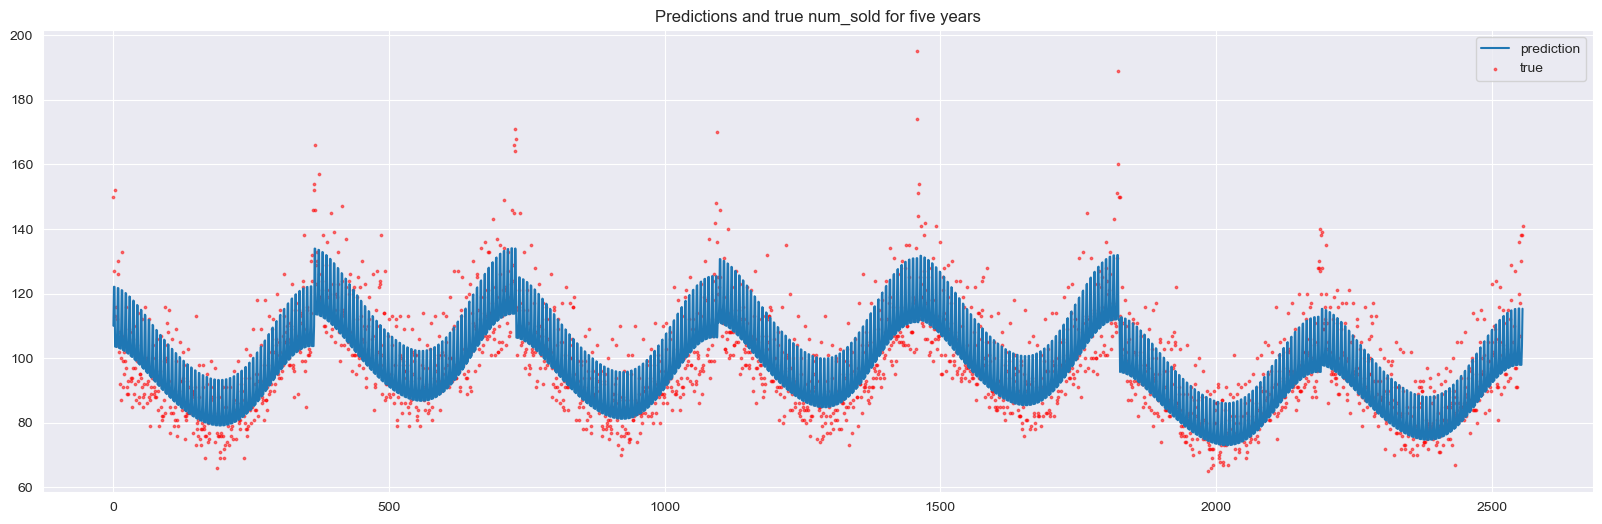

In [156]:
temp_train_df = train_df.copy()
# dropping the Nan values from the temp_train_df
temp_train_df.dropna(inplace=True)
preproc, model = fit_model(temp_train_df)


# Plot all num_sold_true and num_sold_pred (five years) for one country-store-product combination
def plot_five_years_combination(engineer, country='Finland', store='Discount Stickers', product='Holographic Goose'):
    demo_df = pd.DataFrame({'row_id': 0,
                            'date': pd.date_range('2010-01-01', '2016-12-31', freq='D'),
                            'country': country,
                            'store': store,
                            'product': product})
    demo_df.set_index('date', inplace=True, drop=False)
    demo_df = engineer(demo_df)
    demo_df['num_sold'] = np.exp(model.predict(preproc.transform(demo_df[features])))
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(len(demo_df)), demo_df.num_sold, label='prediction')
    train_subset = train_df[(original_train_df.country == country) & (original_train_df.store == store) & (original_train_df['product'] == product)]
    plt.scatter(np.arange(len(train_subset)), train_subset.num_sold, label='true', alpha=0.5, color='red', s=3)
    plt.legend()
    plt.title('Predictions and true num_sold for five years')
    plt.show()

plot_five_years_combination(engineer)


In [164]:
np.std(residuals)

5.394969940185547

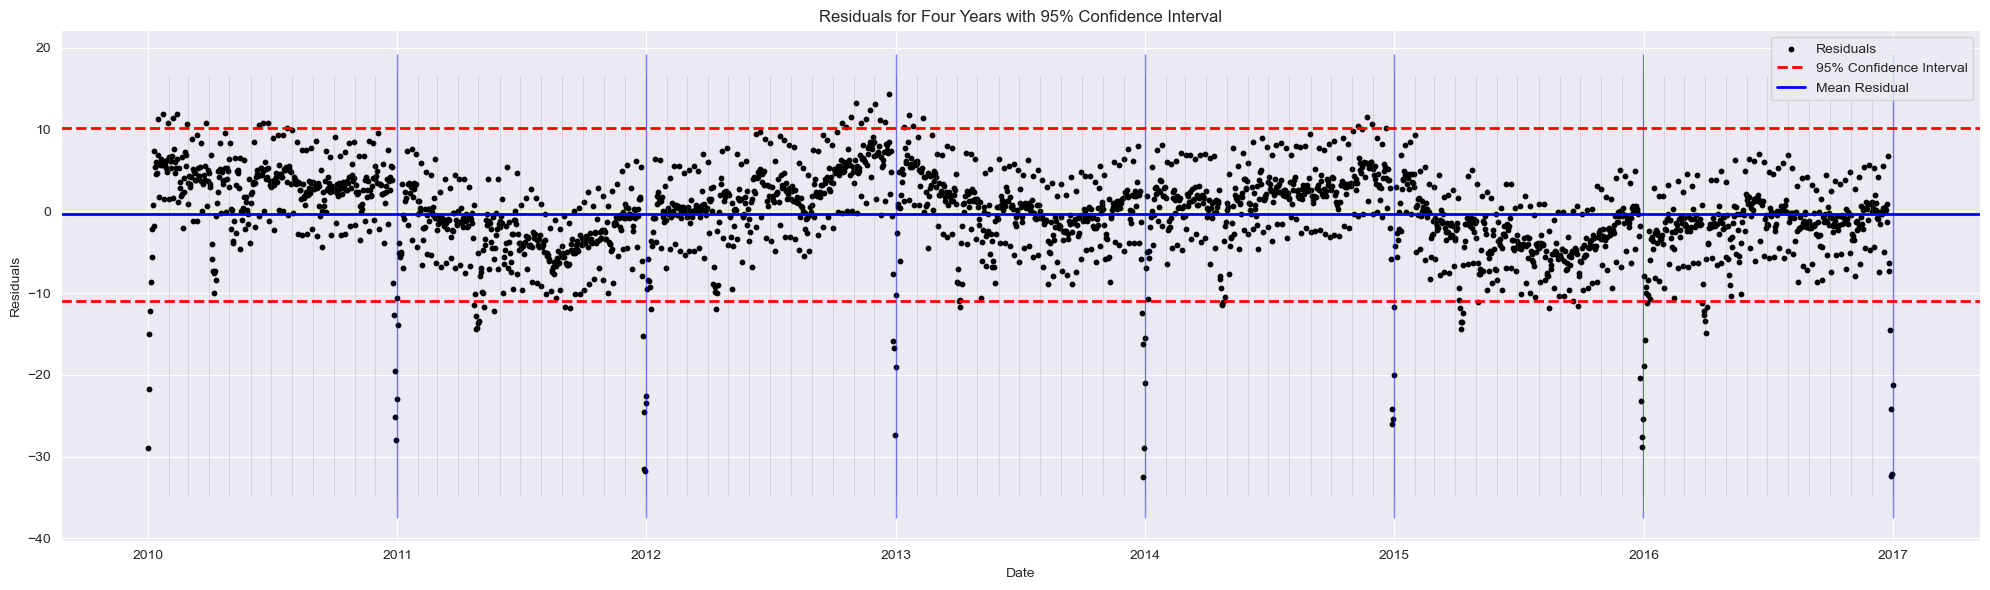

In [165]:
# Make predictions and compute residuals
temp_train_df['pred'] = np.exp(model.predict(preproc.transform(temp_train_df[features])))
by_date = temp_train_df.groupby(temp_train_df['date'])
residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200

# Plot all residuals with 95% confidence interval
def plot_all_residuals(residuals):
    plt.figure(figsize=(20, 6))
    
    # Scatter plot of residuals
    plt.scatter(residuals.index, residuals, s=10, color='k', label='Residuals')
    
    # Add vertical lines for each month
    plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='M'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.3, color='gray', linewidth=0.5)
    
    # Add vertical lines for each year
    plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='Y'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5, color='blue', linewidth=1)
    
    # Calculate 95% confidence interval
    mean_resid = residuals.mean()
    std_resid = residuals.std()
    ci_lower = mean_resid - 1.96 * std_resid
    ci_upper = mean_resid + 1.96 * std_resid
    
    # Plot horizontal lines for the confidence interval
    plt.axhline(ci_upper, color='red', linestyle='--', linewidth=2, label='95% Confidence Interval')
    plt.axhline(ci_lower, color='red', linestyle='--', linewidth=2)
    
    # Optionally, plot the mean residual
    plt.axhline(mean_resid, color='blue', linestyle='-', linewidth=2, label='Mean Residual')
    
    # Add titles and labels
    plt.title('Residuals for Four Years with 95% Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_all_residuals(residuals)


In [166]:
# Find the days that are outliers We first calculate the 95% confidence interval for the residuals, and then find the days where the residuals are outside this interval.
ci_lower = residuals.mean() - 1.96 * residuals.std()
ci_upper = residuals.mean() + 1.96 * residuals.std()
outliers = residuals[(residuals > ci_upper) | (residuals < ci_lower)]

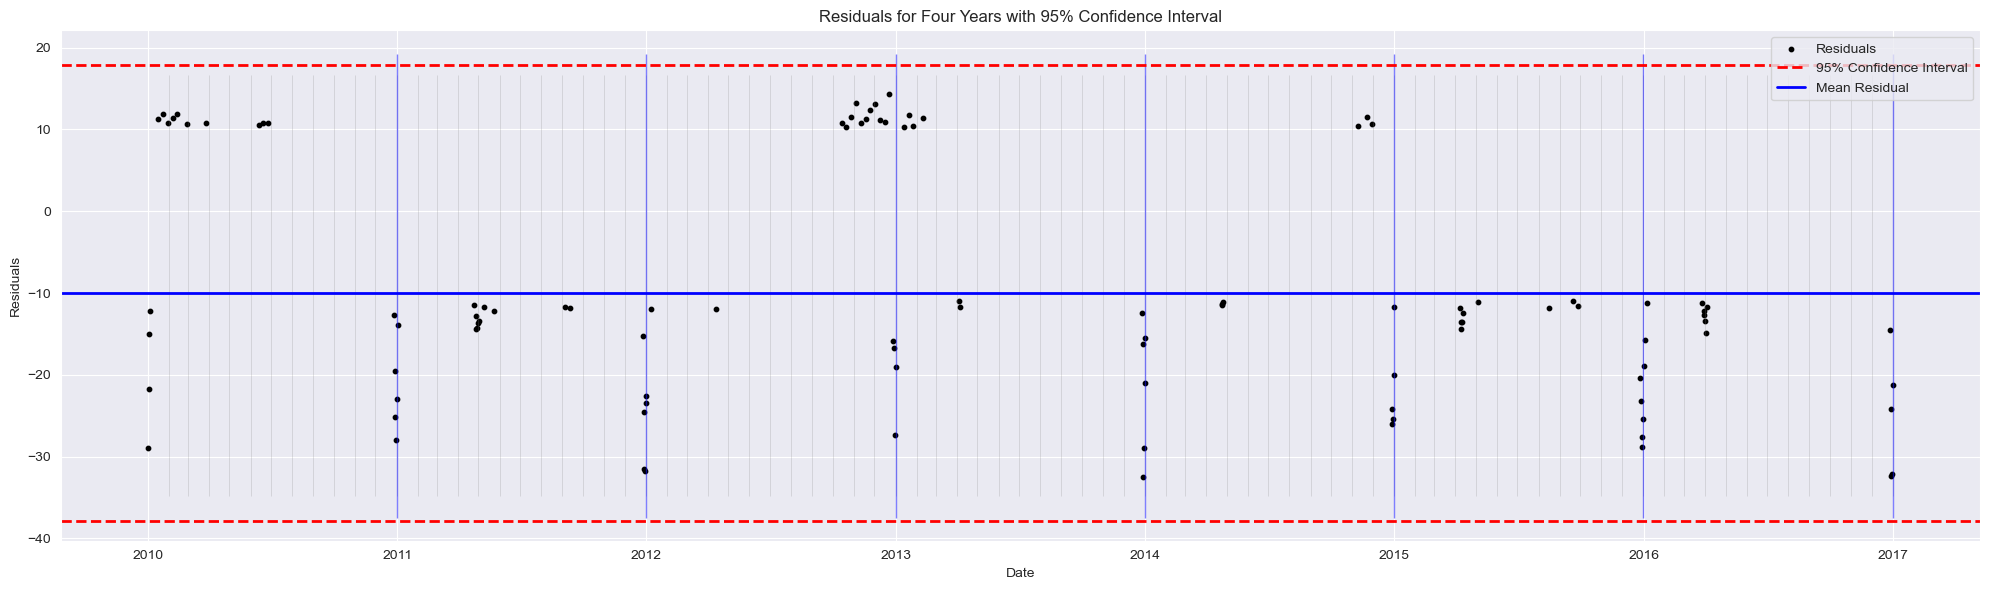

In [175]:
plot_all_residuals(outliers)


In [174]:
# find the value of the residual at 2010-01-16
print(ci_lower,residuals['2010-01-16'],ci_upper)

-10.930204260349273 11.310122 10.222214448451995


In [169]:
outliers

date
2010-01-01   -28.888283
2010-01-02   -15.035489
2010-01-03   -21.747225
2010-01-04   -12.164965
2010-01-16    11.310122
                ...    
2016-12-27   -14.500663
2016-12-28   -24.129278
2016-12-29   -32.399139
2016-12-30   -32.094273
2016-12-31   -21.289936
Length: 104, dtype: float32

In [158]:
# Plot residuals for interesting intervals
def plot_around(residuals, m, d, w, y0=2010, y1=2017):
    """Plot residuals in an interval of with 2*w around month=m and day=d"""
    plt.figure()
    plt.title(f"Residuals around m={m} d={d} y={y0}")
    for y in np.arange(y0, y1):
        d0 = pd.Timestamp(date(y, m, d))
        residual_range = residuals[(residuals.index > d0 - timedelta(w)) & 
                                   (residuals.index < d0 + timedelta(w))]
        
        plt.plot([(r - d0).days for r in residual_range.index], residual_range, label=str(y))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    plt.legend()
    plt.show()

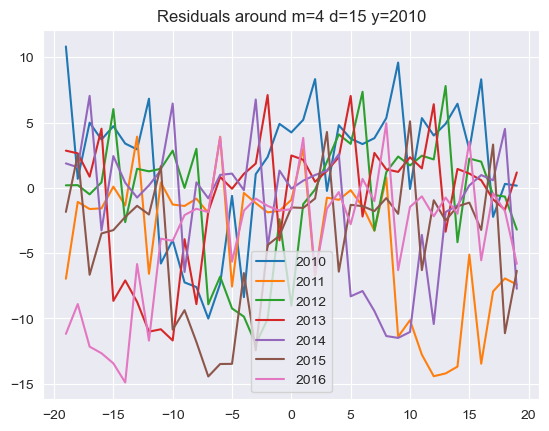

In [162]:
# Norway special days
# New year
plot_around(residuals, 4, 15, 20,2010,2017) # three moveable peaks depending on Easter  ==>0,7
# plot_around(residuals, 1, 1, 15,2011,2012) # three moveable peaks depending on Easter ==> -7,7
# plot_around(residuals, 1, 1, 15,2012,2013) # three moveable peaks depending on Easter   ==> -8,12
# plot_around(residuals, 1, 1, 15,2013,2014) # three moveable peaks depending on Easter     ==>  -6,1
# plot_around(residuals, 1, 1, 10,2014,2015) # three moveable peaks depending on Easter       ==>  -8,3
# plot_around(residuals, 1, 1, 10,2015,2016) # three moveable peaks depending on Easter         ==>-6, 2
# plot_around(residuals, 1, 1, 10,2016,2017) # three moveable peaks depending                       ==> -8, 8

In [83]:
# Norway special days
# Easter
# plot_around(residuals, 4, 1, 15,2010,2011) # three moveable peaks depending on Easter      ===> 3,11
# plot_around(residuals, 5, 1, 15,2011,2012) # three moveable peaks depending on Easter      ===>  -8,11
# plot_around(residuals, 4, 22, 20,2012,2013) # three moveable peaks depending on Easter   ===> -15,0
# plot_around(residuals, 4, 1, 10,2013,2014) # three moveable peaks depending on Easter      ===> -2,8
# plot_around(residuals, 4, 26, 15,2014,2015) # three moveable peaks depending on Easter    ===>  -7,13
# plot_around(residuals, 4, 10, 10,2015,2016) # three moveable peaks depending on Easter   ===>     -6,7
# plot_around(residuals, 4, 1, 15,2016,2017) # three moveable peaks depending                ===> -6, 8



In [107]:
# Valentine
# plot_around(residuals, 2, 15, 15,2010,2011) # three moveable peaks depending on Valentine ==> Nothing
# plot_around(residuals,2, 15, 15,2011,2012) # three moveable peaks depending on Valentine ==> Nothing
# plot_around(residuals, 2, 15, 15,2012,2013) # three moveable peaks depending on Valentine ==> Nothing
# plot_around(residuals, 2, 15, 15,2013,2014) # three moveable peaks depending on Valentine ==> Nothing
# plot_around(residuals, 2, 15, 15,2014,2015) # three moveable peaks depending on Valentine ==> Nothing
# plot_around(residuals, 2, 15, 15,2015,2016) # three moveable peaks depending on Valentine ==> Nothing
# plot_around(residuals,2, 15, 15,2016,2017) # three moveable peaks depending on Valentine ==> the day of valentine is a peak


In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

def engineer_more(df):
    """Return a new dataframe with more engineered features."""
    # Start with the original engineered features
    new_df = engineer(df)
    
    #
    # 1) Remove or comment out the original Easter and Christmas feature engineering
    #
    # Commenting out the original Easter logic
    # easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    # new_df = pd.concat([new_df,
    #                     pd.DataFrame({f"easter{d}": 
    #                                   (df.date - easter_date == np.timedelta64(d, "D"))
    #                                   for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})],
    #                    axis=1)
    
    # Commenting out the original Christmas logic for Norway
    # new_df = pd.concat([new_df,
    #                     pd.DataFrame({f"n-dec{d}":
    #                                   (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
    #                                   for d in range(24, 32)}),
    #                     # ... other Christmas-related features ...
    #                    ], axis=1)
    
    #
    # 2) Define explicit date ranges for Norway’s Easter
    #
    # List of (start_date, end_date) tuples for Norway's Easter per year
    norway_easter_ranges = [
        ("2010-04-03", "2010-04-11"),
        ("2011-04-22", "2011-05-11"),
        ("2012-04-07", "2012-04-22"),
        ("2013-03-29", "2013-04-08"),
        ("2014-04-19", "2014-05-07"),
        ("2015-04-04", "2015-04-17"),
        ("2016-03-24", "2016-04-08"),
    ]
    
    # Generate a list of all dates within Norway's Easter ranges
    norway_easter_dates = []
    for start_str, end_str in norway_easter_ranges:
        start_date = pd.to_datetime(start_str)
        end_date = pd.to_datetime(end_str)
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        norway_easter_dates.extend(date_range)
    
    # Create separate feature columns for each day in Norway's Easter ranges
    norway_easter_features = {
        f"n-easter_{date.strftime('%Y_%m_%d')}": ((df['country'] == 'Norway') & (df['date'] == date))
        for date in norway_easter_dates
    }
    
    # Convert boolean to float32
    norway_easter_df = pd.DataFrame(norway_easter_features).astype(np.float32)
    
    # Concatenate to new_df
    new_df = pd.concat([new_df, norway_easter_df], axis=1)
    
    #
    # 3) Define explicit date ranges for Norway’s Christmas
    #
    # List of (start_date, end_date) tuples for Norway's Christmas per year
    norway_christmas_ranges = [
        ("2010-01-01", "2010-01-07"),       # Adjusted based on your input
        ("2011-12-24", "2012-01-07"),
        ("2012-12-22", "2013-01-12"),
        ("2013-12-25", "2014-01-02"),
        ("2014-12-22", "2015-01-04"),
        ("2015-12-24", "2016-03-01"),       # Note: 2015-03-01 seems incorrect; likely a typo
        ("2016-12-22", "2017-01-08"),
    ]
    
    # **Important**: Verify the correctness of the 2015 Christmas range
    # The end date "2016-03-01" seems unusual for Christmas. Adjust if necessary.
    
    # Generate a list of all dates within Norway's Christmas ranges
    norway_christmas_dates = []
    for start_str, end_str in norway_christmas_ranges:
        start_date = pd.to_datetime(start_str)
        end_date = pd.to_datetime(end_str)
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        norway_christmas_dates.extend(date_range)
    
    # Create separate feature columns for each day in Norway's Christmas ranges
    norway_christmas_features = {
        f"n-christmas_{date.strftime('%Y_%m_%d')}": ((df['country'] == 'Norway') & (df['date'] == date))
        for date in norway_christmas_dates
    }
    
    # Convert boolean to float32
    norway_christmas_df = pd.DataFrame(norway_christmas_features).astype(np.float32)
    
    # Concatenate to new_df
    new_df = pd.concat([new_df, norway_christmas_df], axis=1)
    
    #
    # 4) (Optional) Add other holidays for Norway similarly
    #
    # For example, Valentine's Day (Feb 14) for Norway
    # norway_valentine_features = {
    #     "n-valentine": ((df['country'] == 'Norway') & (df['date'].dt.month == 2) & (df['date'].dt.day == 14))
    # }
    # new_df = pd.concat([new_df, pd.DataFrame(norway_valentine_features).astype(np.float32)], axis=1)
    
    #
    # 5) Continue with other feature engineering as in original code
    #
    # Existing feature engineering for December, May, June, July, etc.
    # Ensure that these remain unaffected unless they overlap with the newly defined features
    
    # Example: Keeping existing December features excluding Norway's original ones
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                                      for d in range(24, 32)}),
                        # Other country-specific features remain as-is
                        pd.DataFrame({f"f-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in range(1, 14)}),
                        pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in range(1, 15)})],
                       axis=1)
    
    # May
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10))}),  # + list(range(17, 25))
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in list(range(19, 26))})],
                       axis=1)
    
    # June and July
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in list(range(8, 14))}),
                        # Uncomment if you need Norway's June and July features
                        # pd.DataFrame({f"june{d}":
                        #               (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #               for d in list(range(22, 31))}),
                        # pd.DataFrame({f"july{d}":
                        #               (df.date.dt.month == 7) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #               for d in list(range(1, 3))})},
                       ],
                       axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({
        2015: pd.Timestamp('2015-06-24'),
        2016: pd.Timestamp('2016-06-29'),
        2017: pd.Timestamp('2017-06-28'),
        2018: pd.Timestamp('2018-06-27'),
        2019: pd.Timestamp('2019-06-26')
    })
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"wed_june{d}": 
                                      ((df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway'))
                                      for d in list(range(-4, 6))})],
                       axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({
        2015: pd.Timestamp('2015-11-01'),
        2016: pd.Timestamp('2016-11-06'),
        2017: pd.Timestamp('2017-11-05'),
        2018: pd.Timestamp('2018-11-04'),
        2019: pd.Timestamp('2019-11-03')
    })
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      ((df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway'))
                                      for d in list(range(0, 9))})],
                       axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December)
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in list(range(6, 14))})],
                       axis=1)
    
    # Easter (Other countries if needed)
    # If you still need to engineer Easter features for other countries, keep the original logic
    # Uncomment and adjust if necessary
    # easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    # new_df = pd.concat([new_df,
    #                     pd.DataFrame({f"easter{d}": 
    #                                   (df.date - easter_date == np.timedelta64(d, "D"))
    #                                   for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})],
    #                    axis=1)
    
    # Add any other holiday features as needed
    
    # Finally, convert all feature columns to float32
    return new_df.astype(np.float32)

# Apply feature engineering
train_df = engineer_more(original_train_df.dropna(inplace=False))
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)

test_df = engineer_more(original_test_df)
# test_df['date'] = train_df_imputed.date

# Ensure consistent feature types
features = test_df.columns
for df in [train_df, test_df]:
    for feature in features:
        if feature not in ['date', 'num_sold']:
            df[feature] = df[feature].astype(np.float32)

print(list(features))


['gdp', 'wd4', 'wd56', 'Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore', 'Discount Stickers', 'Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode', 'sin1', 'cos1', 'Holographic_Goose_sin1', 'Holographic_Goose_cos1', 'Kaggle_sin1', 'Kaggle_cos1', 'Kaggle_Tiers_sin1', 'Kaggle_Tiers_cos1', 'Kerneler_sin1', 'Kerneler_cos1', 'Kerneler_Dark_Mode_sin1', 'Kerneler_Dark_Mode_cos1', 'sin2', 'cos2', 'Holographic_Goose_sin2', 'Holographic_Goose_cos2', 'Kaggle_sin2', 'Kaggle_cos2', 'Kaggle_Tiers_sin2', 'Kaggle_Tiers_cos2', 'Kerneler_sin2', 'Kerneler_cos2', 'Kerneler_Dark_Mode_sin2', 'Kerneler_Dark_Mode_cos2', 'n-easter_2010_04_03', 'n-easter_2010_04_04', 'n-easter_2010_04_05', 'n-easter_2010_04_06', 'n-easter_2010_04_07', 'n-easter_2010_04_08', 'n-easter_2010_04_09', 'n-easter_2010_04_10', 'n-easter_2010_04_11', 'n-easter_2011_04_22', 'n-easter_2011_04_23', 'n-easter_2011_04_24', 'n-easter_2011_04_25', 'n-easter_2011_04_26', 'n-easter_2011_04_27', 'n-easter_20

In [142]:
features

Index(['gdp', 'wd4', 'wd56', 'Canada', 'Finland', 'Italy', 'Kenya', 'Norway',
       'Singapore', 'Discount Stickers', 'Holographic Goose', 'Kaggle',
       'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode', 'sin1', 'cos1',
       'Holographic_Goose_sin1', 'Holographic_Goose_cos1', 'Kaggle_sin1',
       'Kaggle_cos1', 'Kaggle_Tiers_sin1', 'Kaggle_Tiers_cos1',
       'Kerneler_sin1', 'Kerneler_cos1', 'Kerneler_Dark_Mode_sin1',
       'Kerneler_Dark_Mode_cos1', 'sin2', 'cos2', 'Holographic_Goose_sin2',
       'Holographic_Goose_cos2', 'Kaggle_sin2', 'Kaggle_cos2',
       'Kaggle_Tiers_sin2', 'Kaggle_Tiers_cos2', 'Kerneler_sin2',
       'Kerneler_cos2', 'Kerneler_Dark_Mode_sin2', 'Kerneler_Dark_Mode_cos2',
       'norway_easter', 'norway_christmas', 'norway_valentine'],
      dtype='object')

C:\Users\goatp\AppData\Local\Temp\ipykernel_44596\2509513612.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_subset = train_df[(original_train_df.country == country) & (original_train_df.store == store) & (original_train_df['product'] == product)]


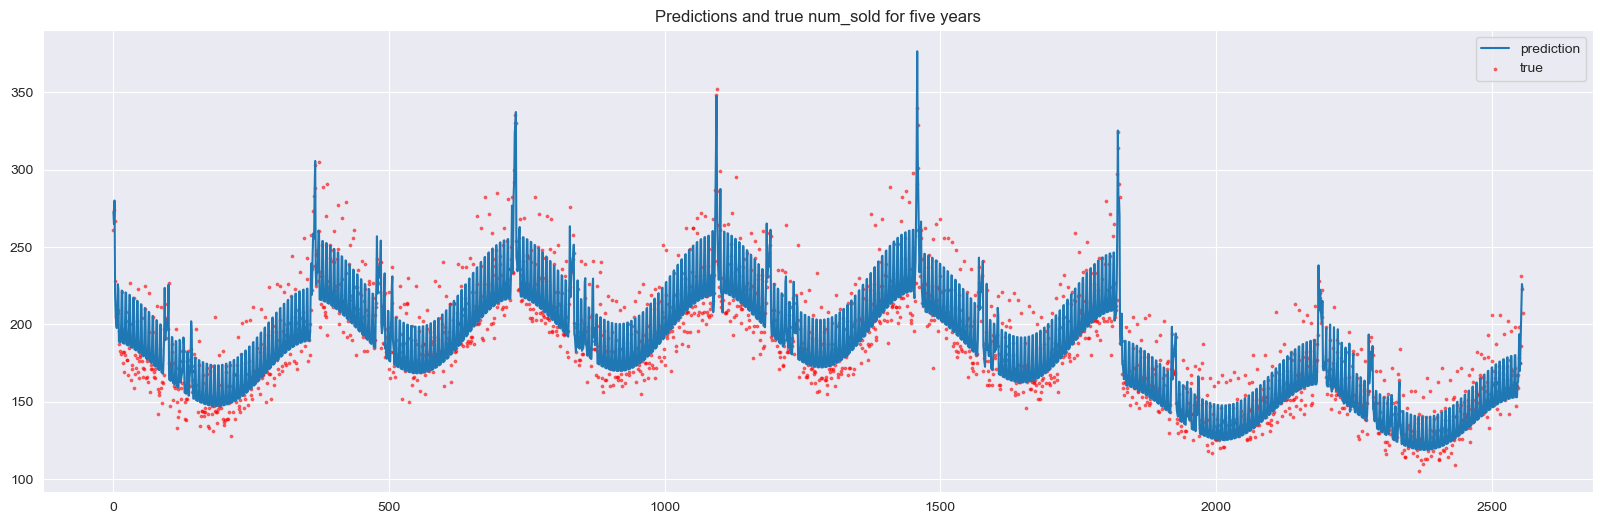

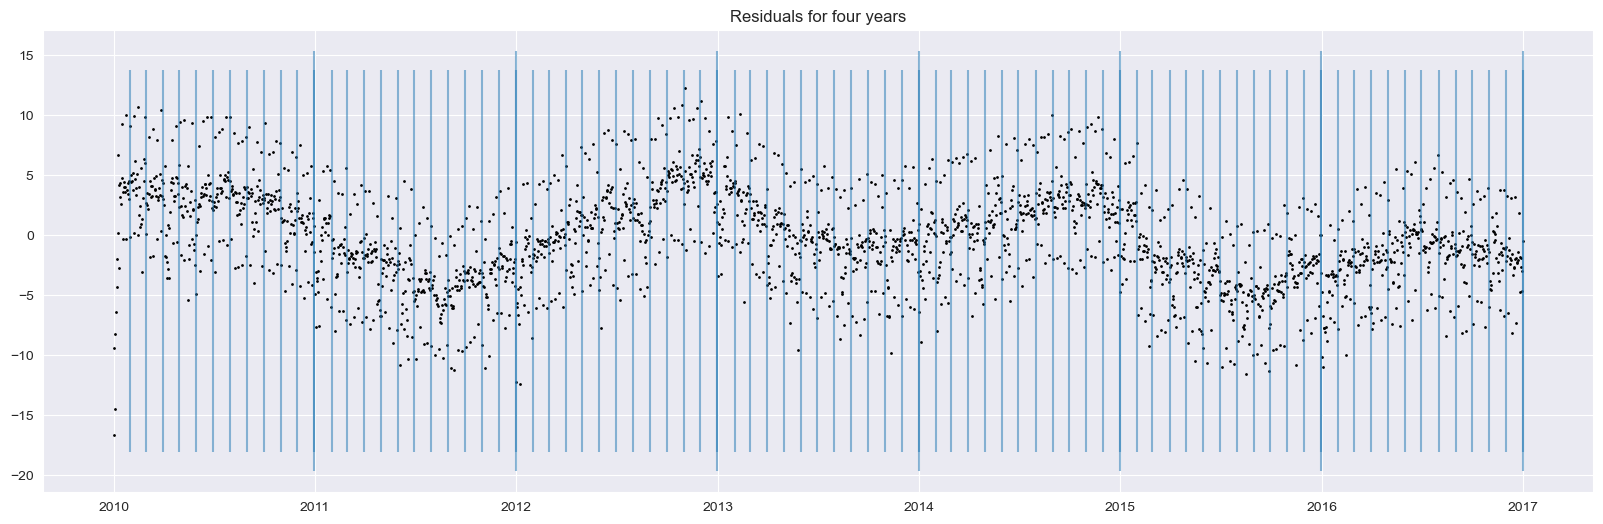

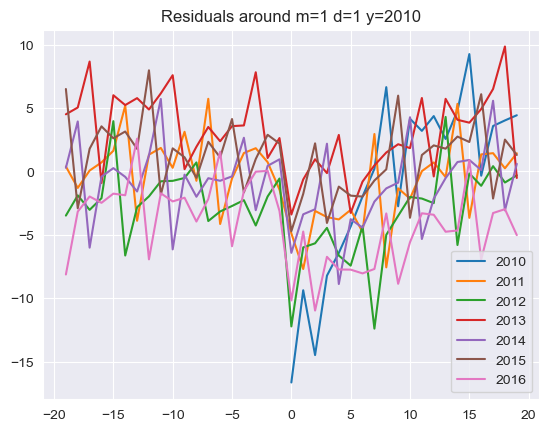

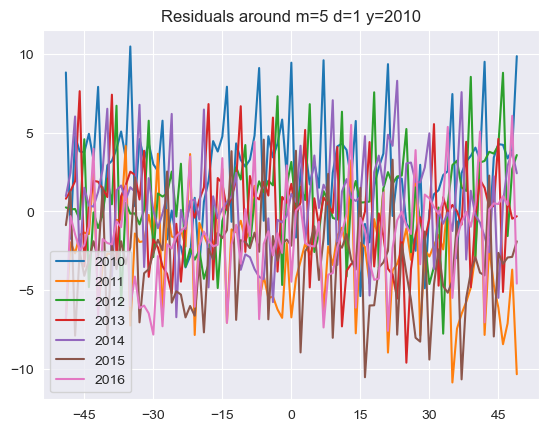

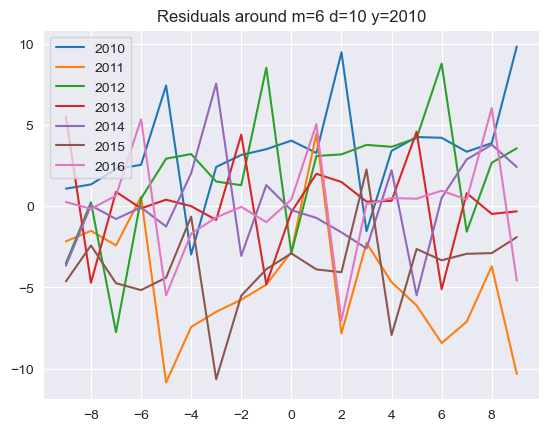

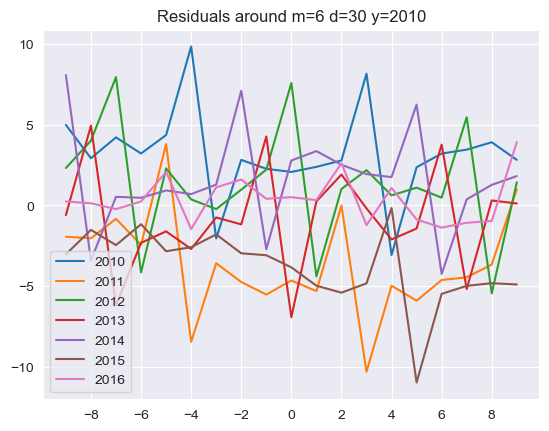

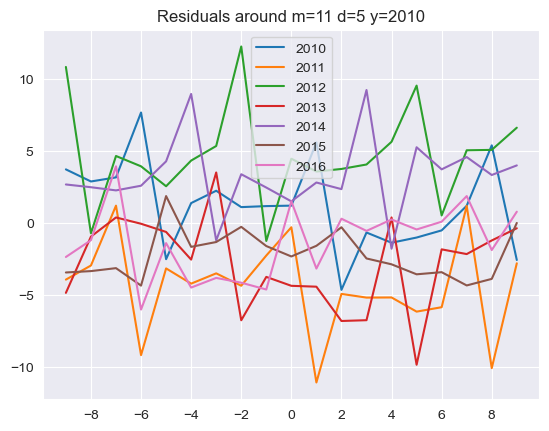

In [146]:
temp_train_df = train_df.copy()
# dropping the Nan values from the temp_train_df
temp_train_df.dropna(inplace=True)
preproc, model = fit_model(temp_train_df)


temp_train_df['pred'] = np.exp(model.predict(preproc.transform(temp_train_df[features])))
# with open('train_pred.pickle', 'wb') as handle: pickle.dump(temp_train_df.pred, handle) # save residuals for further analysis
by_date = temp_train_df.groupby(temp_train_df['date'])
residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200

# Plot all num_sold_true and num_sold_pred (five years) for one country-store-product combination
plot_five_years_combination(engineer_more)

# Plot all residuals (four-year range, sum of all products)
plot_all_residuals(residuals)

# # Plot residuals for interesting intervals
plot_around(residuals, 1, 1, 20) # end of year peak
plot_around(residuals, 5, 1, 50) # three moveable peaks depending on Easter
#plot_around(residuals, 5, 21, 10) # zoom-in
#plot_around(residuals, 5, 31, 15) # zoom-in
plot_around(residuals, 6, 10, 10) # first half of June (with overlay of Pentecost in 2017)
plot_around(residuals, 6, 30, 10) # moveable peak end of June
plot_around(residuals, 11, 5, 10) # moveable peak beginning of November


In [180]:
gdp_per_capita_df

,Country Name,Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24712.493263,26441.619936,26893.011506,28396.908423,28452.170615,29350.805019,30253.279358,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,147.612227,147.014904,156.189192,182.243917,162.347592,180.214908,190.845484,192.337167,...,1736.166560,1713.899299,1703.596298,1549.037940,1431.778723,1573.063386,1574.978648,1530.059177,1359.618224,NaN
2,Afghanistan,AFG,59.773234,59.860900,58.458009,78.706429,82.095307,101.108325,137.594298,160.898434,...,638.845852,624.315455,614.223342,556.007221,512.012778,516.679862,485.668419,494.179350,516.747871,NaN
3,Africa Western and Central,AFW,107.932233,113.081647,118.831107,123.442888,131.854402,138.526332,144.326212,128.582470,...,1965.118485,2157.481149,2212.853135,1894.310195,1673.835527,1613.473553,1704.139603,1777.918672,1710.073363,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5100.097027,5254.881126,5408.411700,4166.979833,3506.073128,4095.810057,3289.643995,2809.626088,1776.166868,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3410.859780,3704.784221,3902.676013,3520.766449,3759.560246,4009.380987,4384.048892,4416.108358,4346.637931,NaN
262,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1446.536472,1607.152173,1674.002572,1601.830063,1152.720966,964.264811,758.145242,NaN,NaN,NaN
263,South Africa,ZAF,443.009920,454.962013,473.011405,511.497364,548.996058,584.704163,621.220543,675.135345,...,8222.197279,7467.079185,6988.808739,6259.839681,5756.965741,6690.939847,7005.095413,6624.761865,5655.867654,NaN
264,Zambia,ZMB,232.188564,220.042067,212.578449,213.896759,242.384473,303.281740,343.373670,360.201239,...,1763.069442,1878.346811,1762.427817,1338.290927,1280.806543,1535.196574,1516.368371,1305.001031,985.132436,NaN


# All the countries

In [187]:
import math
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""

    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"] == row.country, str(row.date.year)].values[0]
    
    new_df = pd.DataFrame({
        'gdp': np.log(df.apply(get_gdp, axis=1)),
        'wd4': df.date.dt.weekday == 4,  # Friday
        'wd56': df.date.dt.weekday >= 5,  # Saturday and Sunday
    })

    # One-hot encoding (no need to encode the last categories)
    for country in countries:
        new_df[country] = df.country == country
    new_df['Discount Stickers'] = df.store == 'Discount Stickers'
    for product in ['Holographic Goose' ,'Kaggle' ,'Kaggle Tiers' ,'Kerneler', 'Kerneler Dark Mode']:
        new_df[product] = df['product'] == product

    # Seasonal variations (Fourier series)
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'Holographic_Goose_sin{k}'] = new_df[f'sin{k}'] * new_df['Holographic Goose']
        new_df[f'Holographic_Goose_cos{k}'] = new_df[f'cos{k}'] * new_df['Holographic Goose']
        new_df[f'Kaggle_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle']
        new_df[f'Kaggle_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle']
        new_df[f'Kaggle_Tiers_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Tiers']
        new_df[f'Kaggle_Tiers_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Tiers']
        new_df[f'Kerneler_sin{k}'] = new_df[f'sin{k}'] * new_df['Kerneler']
        new_df[f'Kerneler_cos{k}'] = new_df[f'cos{k}'] * new_df['Kerneler']
        new_df[f'Kerneler_Dark_Mode_sin{k}'] = new_df[f'sin{k}'] * new_df['Kerneler Dark Mode']
        new_df[f'Kerneler_Dark_Mode_cos{k}'] = new_df[f'cos{k}'] * new_df['Kerneler Dark Mode']

    return new_df

# Apply feature engineering
train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)

test_df = engineer(original_test_df)
# test_df['date'] = train_df_imputed.date

# Ensure consistent feature types
features = test_df.columns
for df in [train_df, test_df]:
    for feature in features:
        if feature not in ['date', 'num_sold']:
            df[feature] = df[feature].astype(np.float32)

print(list(features))

def fit_model(X_tr, X_va=None, outliers=False):
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model


# # Plot all residuals with 95% confidence interval
# def plot_all_residuals(residuals):
#     plt.figure(figsize=(20, 6))
    
#     # Scatter plot of residuals
#     plt.scatter(residuals.index, residuals, s=10, color='k', label='Residuals')
    
#     # Add vertical lines for each month
#     plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='M'),
#                plt.ylim()[0], plt.ylim()[1], alpha=0.3, color='gray', linewidth=0.5)
    
#     # Add vertical lines for each year
#     plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='Y'),
#                plt.ylim()[0], plt.ylim()[1], alpha=0.5, color='blue', linewidth=1)
    
#     # Calculate 95% confidence interval
#     mean_resid = residuals.mean()
#     std_resid = residuals.std()
#     ci_lower = mean_resid - 1.96 * std_resid
#     ci_upper = mean_resid + 1.96 * std_resid
    
#     # Plot horizontal lines for the confidence interval
#     plt.axhline(ci_upper, color='red', linestyle='--', linewidth=2, label='95% Confidence Interval')
#     plt.axhline(ci_lower, color='red', linestyle='--', linewidth=2)
    
#     # Optionally, plot the mean residual
#     plt.axhline(mean_resid, color='blue', linestyle='-', linewidth=2, label='Mean Residual')
    
#     # Add titles and labels
#     plt.title('Residuals for Four Years with 95% Confidence Interval')
#     plt.xlabel('Date')
#     plt.ylabel('Residuals')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Call the plotting function
# outliers = residuals[(residuals > ci_upper) | (residuals < ci_lower)]


['gdp', 'wd4', 'wd56', 'Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore', 'Discount Stickers', 'Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode', 'sin1', 'cos1', 'Holographic_Goose_sin1', 'Holographic_Goose_cos1', 'Kaggle_sin1', 'Kaggle_cos1', 'Kaggle_Tiers_sin1', 'Kaggle_Tiers_cos1', 'Kerneler_sin1', 'Kerneler_cos1', 'Kerneler_Dark_Mode_sin1', 'Kerneler_Dark_Mode_cos1', 'sin2', 'cos2', 'Holographic_Goose_sin2', 'Holographic_Goose_cos2', 'Kaggle_sin2', 'Kaggle_cos2', 'Kaggle_Tiers_sin2', 'Kaggle_Tiers_cos2', 'Kerneler_sin2', 'Kerneler_cos2', 'Kerneler_Dark_Mode_sin2', 'Kerneler_Dark_Mode_cos2']


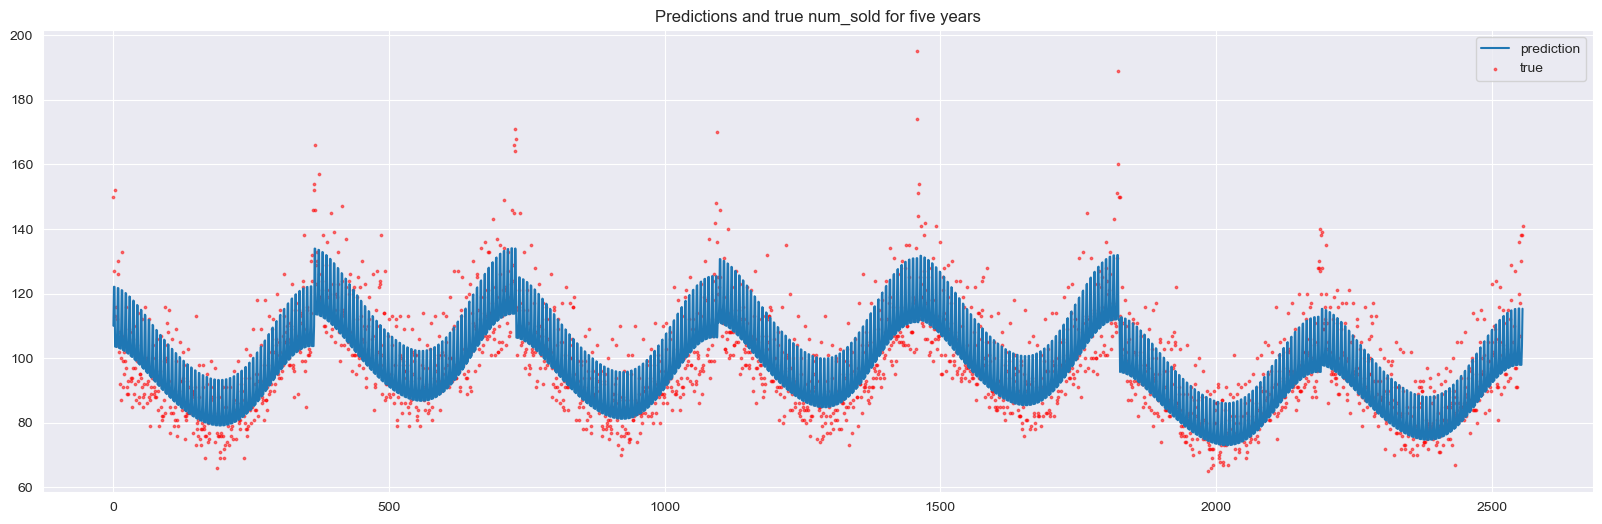

In [189]:

temp_train_df = train_df.copy()
# dropping the Nan values from the temp_train_df
temp_train_df.dropna(inplace=True)
preproc, model = fit_model(temp_train_df)


# Plot all num_sold_true and num_sold_pred (five years) for one country-store-product combination
def plot_five_years_combination(engineer, country='Finland', store='Discount Stickers', product='Holographic Goose'):
    demo_df = pd.DataFrame({'row_id': 0,
                            'date': pd.date_range('2010-01-01', '2016-12-31', freq='D'),
                            'country': country,
                            'store': store,
                            'product': product})
    demo_df.set_index('date', inplace=True, drop=False)
    demo_df = engineer(demo_df)
    demo_df['num_sold'] = np.exp(model.predict(preproc.transform(demo_df[features])))
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(len(demo_df)), demo_df.num_sold, label='prediction')
    train_subset = train_df[(original_train_df.country == country) & (original_train_df.store == store) & (original_train_df['product'] == product)]
    plt.scatter(np.arange(len(train_subset)), train_subset.num_sold, label='true', alpha=0.5, color='red', s=3)
    plt.legend()
    plt.title('Predictions and true num_sold for five years')
    plt.show()

plot_five_years_combination(engineer)


# Make predictions and compute residuals
temp_train_df['pred'] = np.exp(model.predict(preproc.transform(temp_train_df[features])))
by_date = temp_train_df.groupby(temp_train_df['date'])
residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200


--- Canada ---


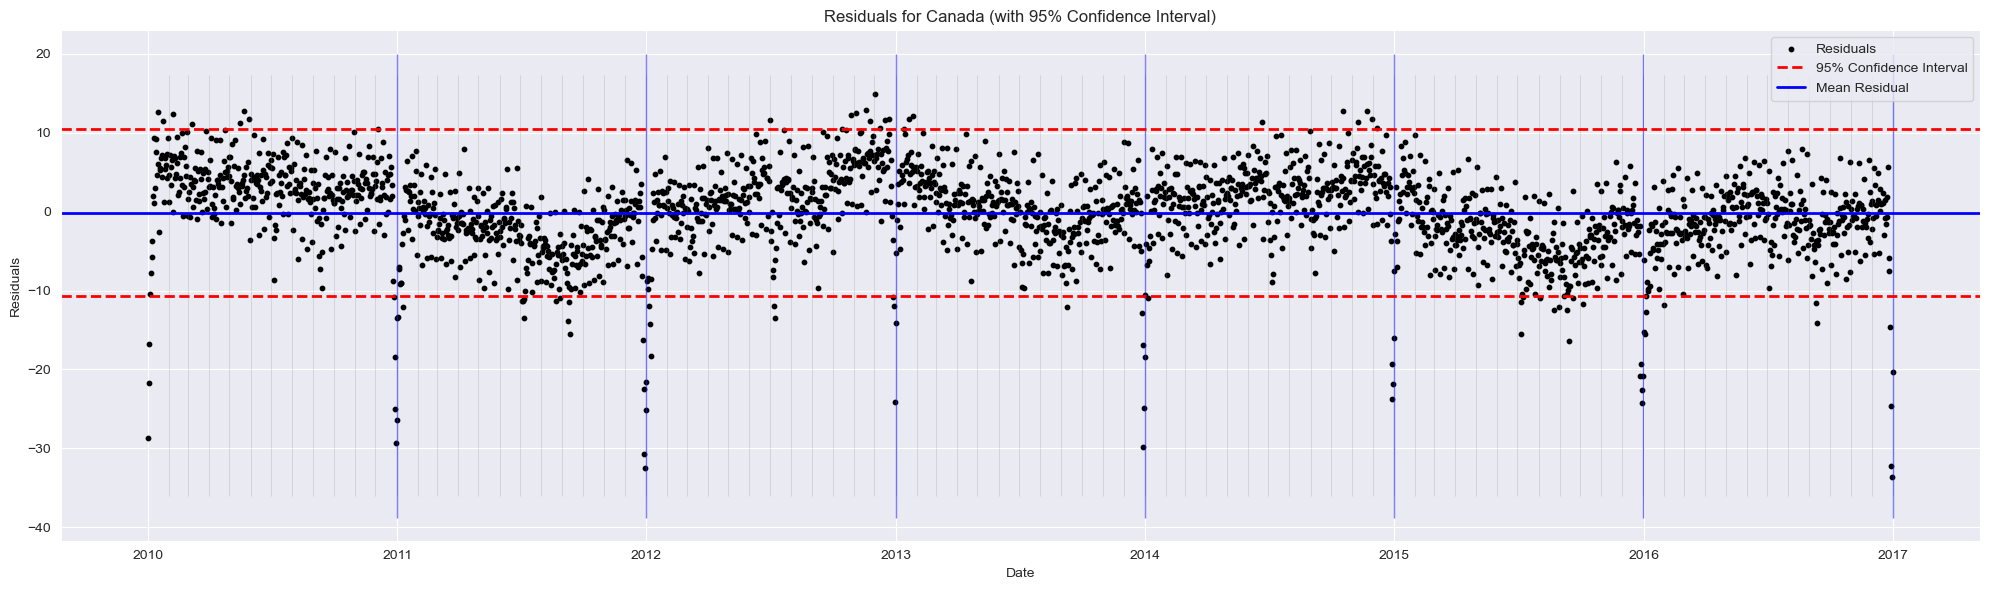

Outlier days for Canada:
['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-16', '2010-01-23', '2010-02-06', '2010-03-06', '2010-05-15', '2010-05-22', '2010-05-29', '2010-12-04', '2010-12-27', '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01', '2011-01-02', '2011-01-09', '2011-07-03', '2011-07-04', '2011-07-05', '2011-07-06', '2011-08-21', '2011-08-28', '2011-09-08', '2011-09-09', '2011-09-11', '2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01', '2012-01-05', '2012-01-06', '2012-01-08', '2012-06-30', '2012-07-06', '2012-07-08', '2012-10-13', '2012-10-27', '2012-11-03', '2012-11-17', '2012-11-24', '2012-12-01', '2012-12-08', '2012-12-15', '2012-12-22', '2012-12-28', '2012-12-29', '2012-12-30', '2012-12-31', '2013-01-12', '2013-01-19', '2013-01-26', '2013-09-08', '2013-12-27', '2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31', '2014-01-05', '2014-06-21', '2014-10-18', '2014-11-08', '2014-11-22', '2014-11-29', '2014-12-06', '2014-12

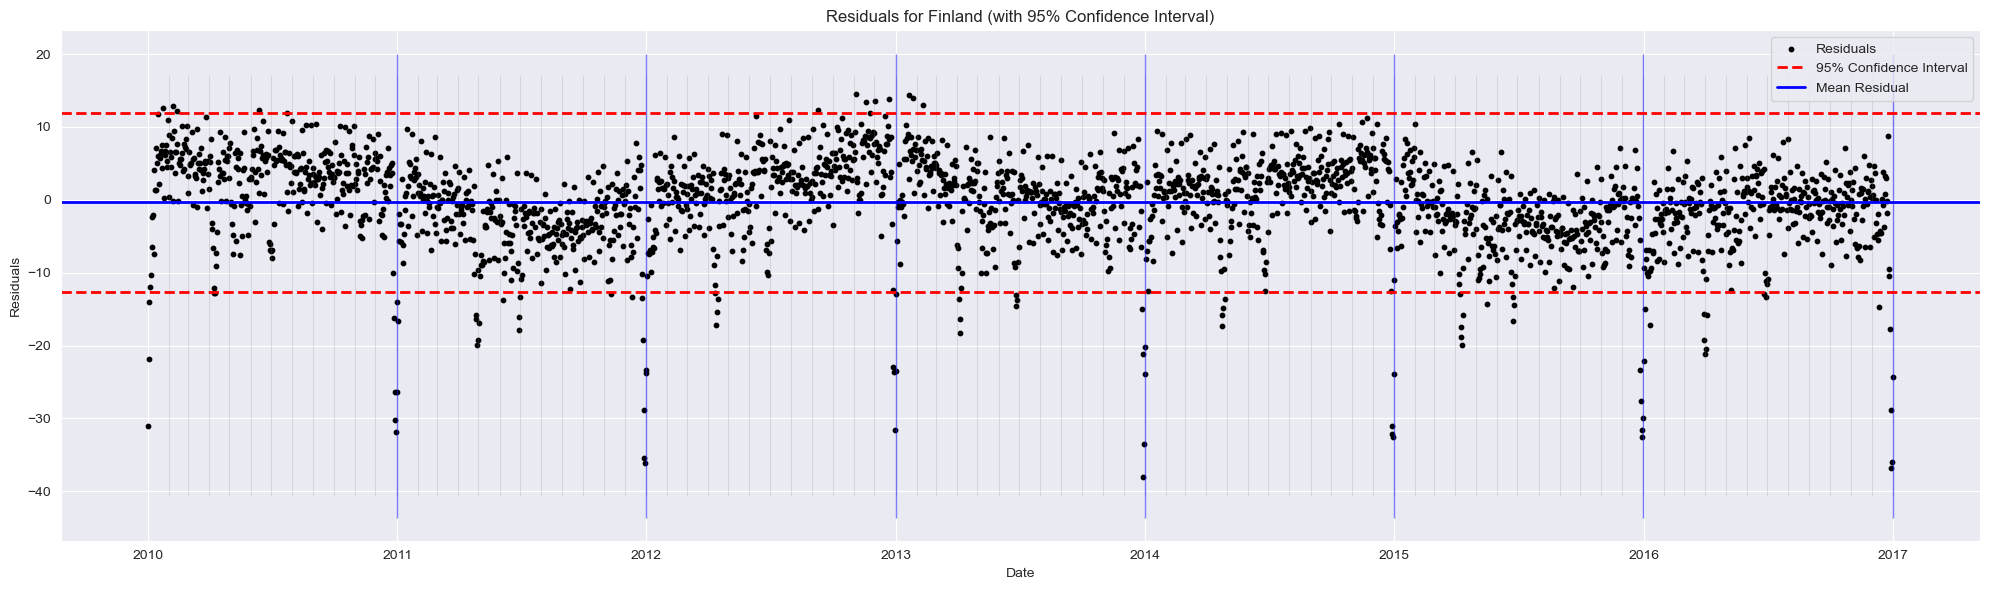

Outlier days for Finland:
['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-23', '2010-02-06', '2010-02-13', '2010-04-08', '2010-04-09', '2010-06-12', '2010-12-27', '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01', '2011-01-02', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-05-01', '2011-06-05', '2011-06-28', '2011-06-29', '2011-06-30', '2011-11-10', '2011-12-11', '2011-12-26', '2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01', '2012-04-11', '2012-04-12', '2012-04-13', '2012-04-15', '2012-09-08', '2012-11-03', '2012-11-17', '2012-12-01', '2012-12-22', '2012-12-28', '2012-12-29', '2012-12-30', '2012-12-31', '2013-01-01', '2013-01-19', '2013-01-26', '2013-02-09', '2013-04-03', '2013-04-04', '2013-04-05', '2013-06-25', '2013-06-26', '2013-06-27', '2013-12-27', '2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31', '2014-01-01', '2014-04-23', '2014-04-24', '2014-04-25', '2014-04-27', '2014-12-28', '2014-12-29', '2014-1

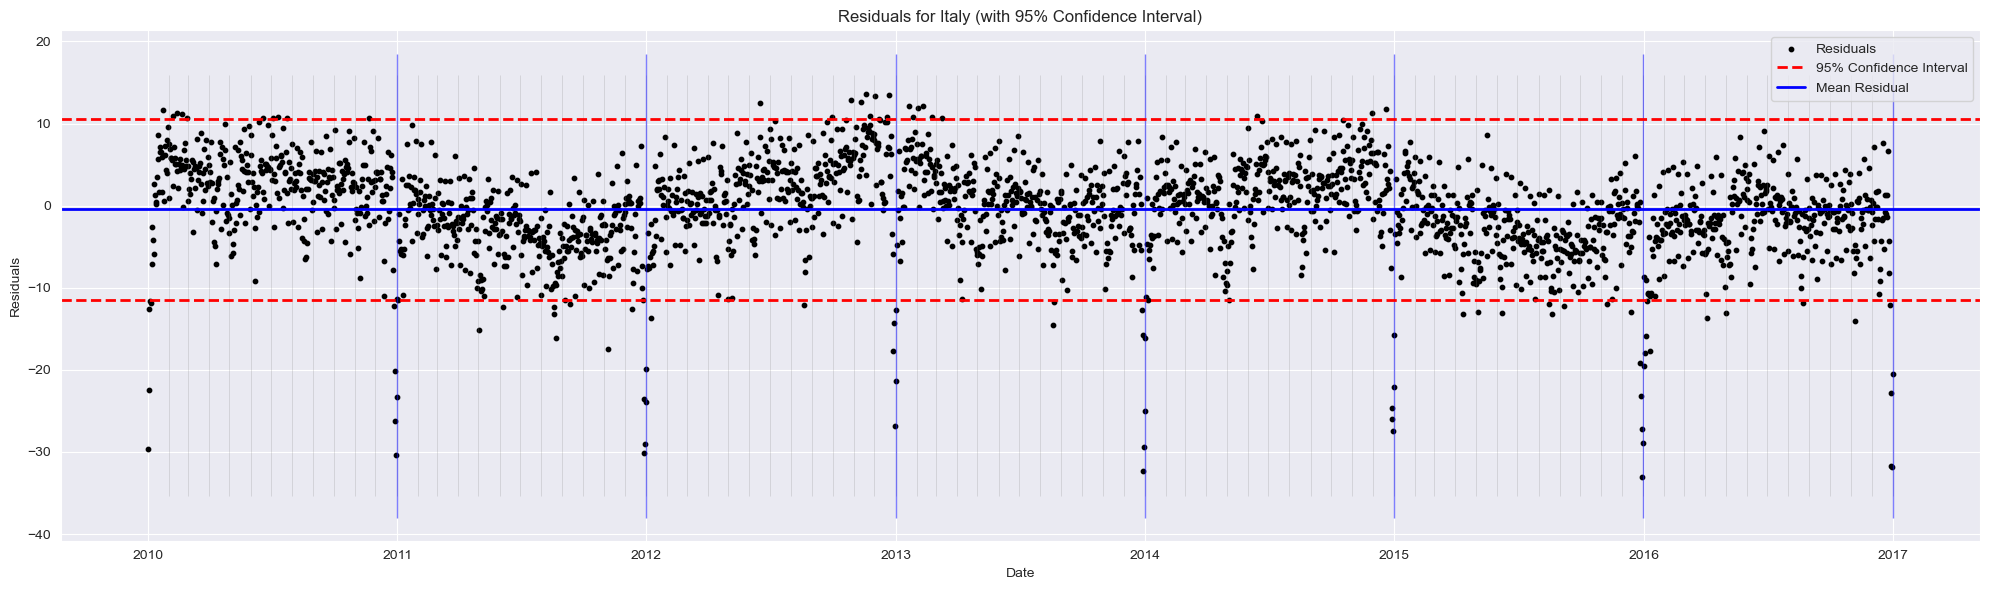

Outlier days for Italy:
['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05', '2010-01-23', '2010-02-06', '2010-02-13', '2010-02-20', '2010-02-27', '2010-06-19', '2010-07-03', '2010-07-10', '2010-07-24', '2010-11-20', '2010-12-27', '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-02', '2011-05-01', '2011-06-05', '2011-08-18', '2011-08-19', '2011-08-21', '2011-09-04', '2011-09-11', '2011-11-06', '2011-12-11', '2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01', '2012-01-08', '2012-06-16', '2012-08-19', '2012-09-29', '2012-10-27', '2012-11-10', '2012-11-17', '2012-11-24', '2012-12-01', '2012-12-19', '2012-12-22', '2012-12-28', '2012-12-29', '2012-12-30', '2012-12-31', '2013-01-01', '2013-01-19', '2013-01-26', '2013-02-02', '2013-02-09', '2013-02-23', '2013-03-09', '2013-08-18', '2013-08-20', '2013-12-27', '2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31', '2014-01-01', '2014-01-05', '2014-05-04', '2014-06-14', '2014-11-

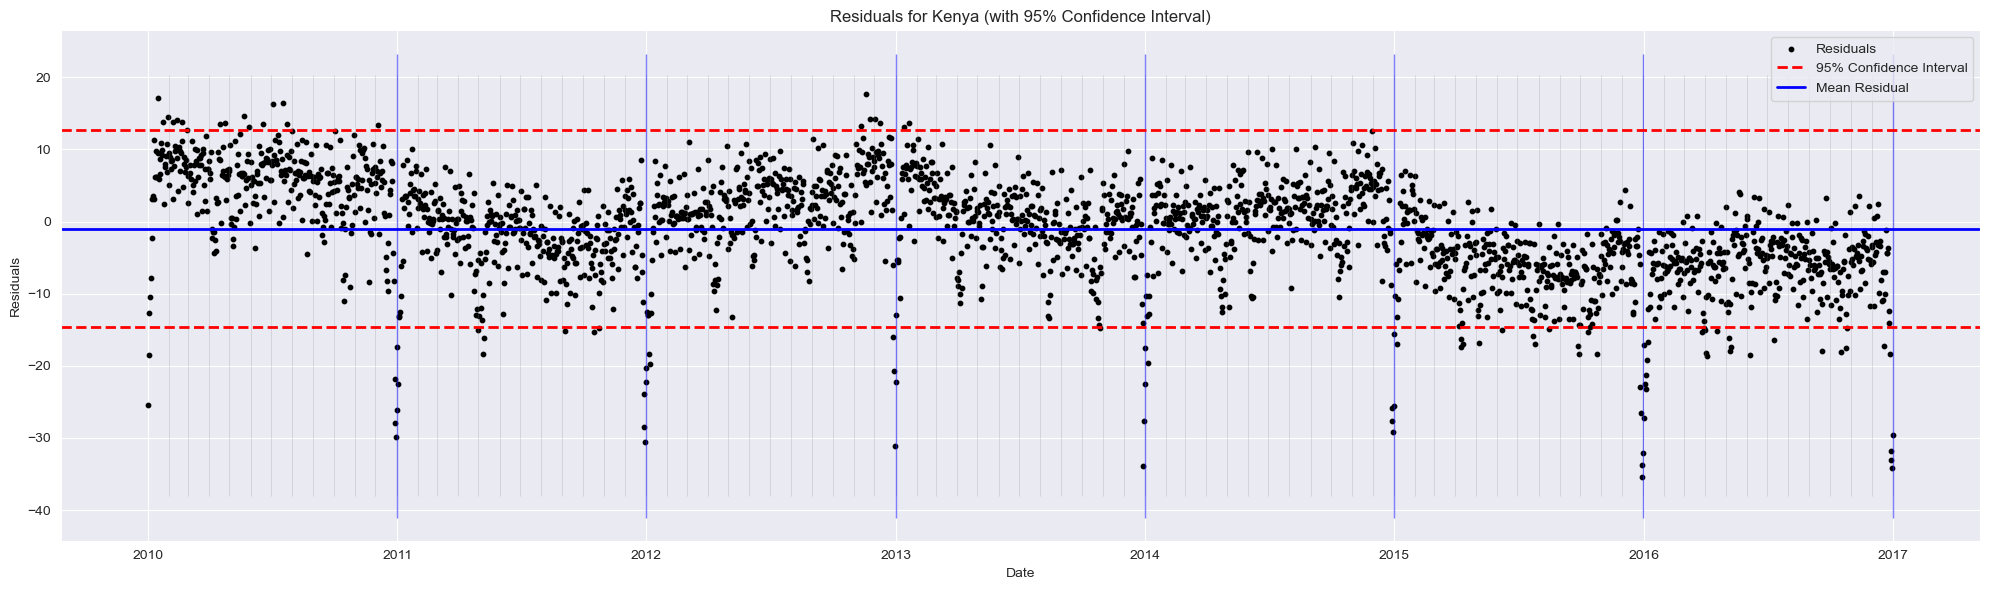

Outlier days for Kenya:
['2010-01-01', '2010-01-03', '2010-01-16', '2010-01-23', '2010-01-30', '2010-02-06', '2010-02-13', '2010-02-20', '2010-02-27', '2010-04-17', '2010-04-24', '2010-05-22', '2010-05-29', '2010-06-19', '2010-07-03', '2010-07-17', '2010-07-24', '2010-12-04', '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01', '2011-01-02', '2011-04-29', '2011-05-06', '2011-05-08', '2011-09-04', '2011-10-16', '2011-10-23', '2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01', '2012-01-05', '2012-01-06', '2012-11-10', '2012-11-17', '2012-11-24', '2012-12-01', '2012-12-08', '2012-12-28', '2012-12-29', '2012-12-30', '2012-12-31', '2013-01-12', '2013-01-19', '2013-10-27', '2013-12-29', '2013-12-30', '2013-12-31', '2014-01-01', '2014-01-05', '2014-12-28', '2014-12-29', '2014-12-30', '2014-12-31', '2015-01-01', '2015-01-04', '2015-04-08', '2015-04-09', '2015-04-12', '2015-05-05', '2015-06-07', '2015-07-23', '2015-07-26', '2015-08-16', '2015-09-27', '2015-09-

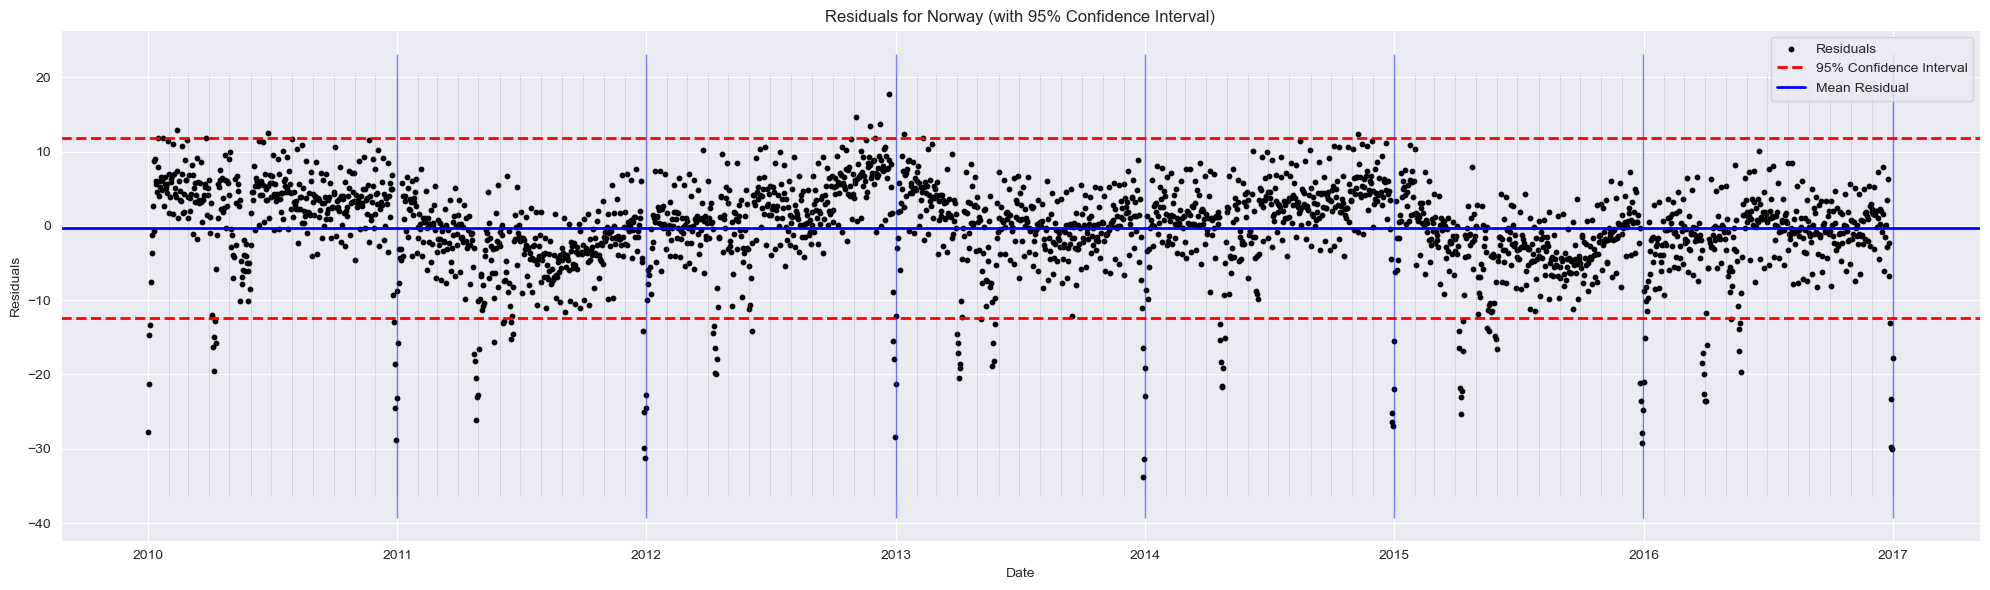

Outlier days for Norway:
['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-16', '2010-01-23', '2010-02-13', '2010-04-06', '2010-04-07', '2010-04-08', '2010-04-09', '2010-04-11', '2010-06-26', '2010-12-27', '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-02', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-05-01', '2011-05-22', '2011-06-05', '2011-06-06', '2011-06-16', '2011-06-17', '2011-06-19', '2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01', '2012-04-08', '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12', '2012-04-13', '2012-06-03', '2012-11-03', '2012-11-24', '2012-12-01', '2012-12-08', '2012-12-22', '2012-12-28', '2012-12-29', '2012-12-30', '2012-12-31', '2013-01-12', '2013-02-09', '2013-03-31', '2013-04-01', '2013-04-02', '2013-04-03', '2013-04-04', '2013-04-05', '2013-05-05', '2013-05-22', '2013-05-23', '2013-05-24', '2013-05-26', '2013-12-28', '2013-12-29', '2013-12

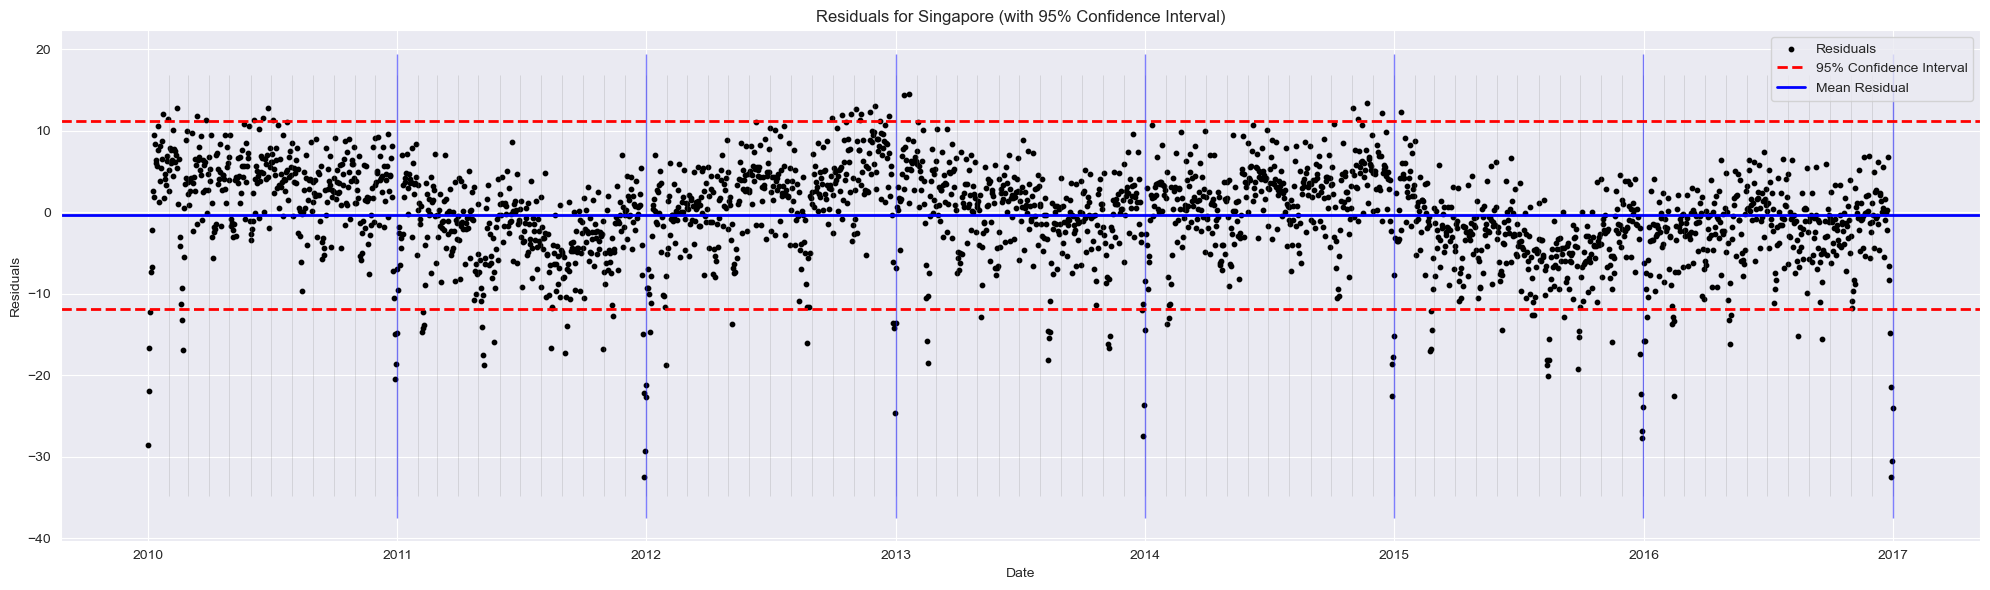

Outlier days for Singapore:
['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-23', '2010-01-30', '2010-02-13', '2010-02-19', '2010-02-21', '2010-03-13', '2010-03-27', '2010-06-05', '2010-06-19', '2010-06-26', '2010-07-03', '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31', '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09', '2011-05-05', '2011-05-06', '2011-05-08', '2011-05-22', '2011-08-14', '2011-09-04', '2011-09-06', '2011-10-30', '2011-11-13', '2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01', '2012-01-06', '2012-01-29', '2012-05-06', '2012-08-24', '2012-09-29', '2012-10-13', '2012-10-27', '2012-11-03', '2012-11-09', '2012-11-10', '2012-11-24', '2012-12-01', '2012-12-22', '2012-12-28', '2012-12-29', '2012-12-30', '2012-12-31', '2013-01-12', '2013-01-19', '2013-02-15', '2013-02-17', '2013-05-05', '2013-08-11', '2013-08-12', '2013-08-13', '2013-08-14', '2013-11-07', '2013-11-08', '2013-11-10', '2013-12-27', '2013-12-29', '2013

In [205]:
def plot_and_list_country_outliers(temp_train_df, preproc, model, features, country):
    """
    Plots daily residuals for a given country, including a 95% confidence interval.
    """
    # Filter dataframe by country
    df_country = temp_train_df[temp_train_df[country] == 1].copy()
        # 2. Compute predictions and residuals
    df_country['pred'] = np.exp(model.predict(preproc.transform(df_country[features])))
    
    # Group by date and sum predictions and actual sales
    by_date_country = df_country.groupby(df_country['date'], as_index=True)
    daily_pred = by_date_country['pred'].sum()
    daily_true = by_date_country['num_sold'].sum()
    
    # Residual formula: percentage difference
    residuals_country = (daily_pred - daily_true) / (daily_pred + daily_true) * 200

    # 3. Plot
    plt.figure(figsize=(20, 6))
    plt.scatter(residuals_country.index, residuals_country, s=10, color='k', label='Residuals')
    
    # Add vertical lines for each month (2010-2017)
    plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='M'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.3, color='gray', linewidth=0.5)
    
    # Add vertical lines for each year (2010-2017)
    plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='Y'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5, color='blue', linewidth=1)
    
    # 4. Compute mean and std of residuals
    mean_resid = residuals_country.mean()
    std_resid = residuals_country.std()
    ci_lower = mean_resid - 1.96 * std_resid
    ci_upper = mean_resid + 1.96 * std_resid
    
    # Plot horizontal lines for the 95% confidence interval
    plt.axhline(ci_upper, color='red', linestyle='--', linewidth=2, label='95% Confidence Interval')
    plt.axhline(ci_lower, color='red', linestyle='--', linewidth=2)
    
    # Plot the mean residual
    plt.axhline(mean_resid, color='blue', linestyle='-', linewidth=2, label='Mean Residual')
    
    plt.title(f'Residuals for {country} (with 95% Confidence Interval)')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 5. Identify and list outlier days
    outliers = residuals_country[(residuals_country < ci_lower) | (residuals_country > ci_upper)]
    
    # Print the outlier dates in YYYY-MM-DD format
    outlier_dates = outliers.index.strftime('%Y-%m-%d').tolist()
    if len(outlier_dates) == 0:
        print(f"No outliers found for {country}.")
    else:
        print(f"Outlier days for {country}:\n{outlier_dates}")
    
    # Return the residuals and outliers for optional further use
    return residuals_country, outliers


all_countries = ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
countries_out = dict()
for country in all_countries:
    
    print(f"\n--- {country} ---")
    residuals_country, outliers_country = plot_and_list_country_outliers(
        temp_train_df, 
        preproc, 
        model, 
        features, 
        country
    )
    countries_out[country] = outliers_country

In [211]:
# remove year from the outliers
cout_no_year = countries_out.copy()
for country in countries_out:
    cout_no_year[country] = countries_out[country].index.date
# drop the year from the outliers
cout_no_year = {k: [str(i)[5:] for i in v] for k, v in cout_no_year.items()}
# Find the common outliers across all countries and list them
common_outliers_no_year = set(cout_no_year['Canada'])
for country in cout_no_year:
    common_outliers_no_year = common_outliers_no_year.intersection(cout_no_year[country])
# Find common outliers for each country in different years meaning the same day in different years
common_outliers = set(countries_out['Canada'].index)
for country in countries_out:
    common_outliers = common_outliers.intersection(countries_out[country].index)


In [218]:
common_outliers

{datetime.date(2010, 1, 1),
 datetime.date(2010, 1, 3),
 datetime.date(2010, 1, 23),
 datetime.date(2010, 12, 28),
 datetime.date(2010, 12, 29),
 datetime.date(2010, 12, 30),
 datetime.date(2010, 12, 31),
 datetime.date(2011, 12, 28),
 datetime.date(2011, 12, 29),
 datetime.date(2011, 12, 30),
 datetime.date(2011, 12, 31),
 datetime.date(2012, 1, 1),
 datetime.date(2012, 12, 1),
 datetime.date(2012, 12, 28),
 datetime.date(2012, 12, 29),
 datetime.date(2012, 12, 30),
 datetime.date(2012, 12, 31),
 datetime.date(2013, 12, 29),
 datetime.date(2013, 12, 30),
 datetime.date(2013, 12, 31),
 datetime.date(2014, 12, 28),
 datetime.date(2014, 12, 29),
 datetime.date(2014, 12, 30),
 datetime.date(2014, 12, 31),
 datetime.date(2015, 12, 27),
 datetime.date(2015, 12, 28),
 datetime.date(2015, 12, 29),
 datetime.date(2015, 12, 30),
 datetime.date(2015, 12, 31),
 datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 3),
 datetime.date(2016, 12, 27),
 datetime.date(2016, 12, 28),
 datetime.date(2016, 1

In [222]:
# find how many times the outliers appear in the data
outliers_counter_country = dict()
for country in cout_no_year:
    outliers_counter_country[country] = {i: cout_no_year[country].count(i) for i in countries_out}


In [234]:
consecutive_outliers = {}  # Dictionary to store consecutive outlier runs for each country

for country in all_countries:
    print(f"\n--- Finding consecutive outlier days for {country} ---")
    outliers_country = countries_out[country]  # This is a Series of outliers; its .index are the outlier dates
    
    if len(outliers_country) == 0:
        print(f"No outliers found for {country}.")
        continue
    
    # Extract and sort outlier dates
    outlier_dates_sorted = sorted(outliers_country.index)
    
    # We’ll iterate through these dates, checking if each date is exactly 1 day after the previous
    # AND in the same year.
    consecutive_runs = []  # List of lists, each list is a run of consecutive outlier days
    current_run = [outlier_dates_sorted[0]]
    
    for i in range(1, len(outlier_dates_sorted)):
        prev_date = outlier_dates_sorted[i - 1]
        curr_date = outlier_dates_sorted[i]
        # Check if current date is 1 day after previous AND in the same year
        if (curr_date == prev_date + pd.Timedelta(days=1)
            and curr_date.year == prev_date.year):
            current_run.append(curr_date)
        else:
            # We’ve hit a break in consecutive days, so finalize the current run
            if len(current_run) > 2:  # strictly more than 3 consecutive days
                consecutive_runs.append(current_run)
            # Start a new run
            current_run = [curr_date]
    
    # After the loop, check the last collected run
    if len(current_run) > 2:
        consecutive_runs.append(current_run)
    
    # Store the result in a dictionary or print directly
    consecutive_outliers[country] = consecutive_runs
    
    if not consecutive_runs:
        print(f"No consecutive runs (of >3 days) found for {country}.")
    else:
        print(f"Consecutive outlier runs (each >3 days) for {country}:")
        for run in consecutive_runs:
            # Convert each run’s dates to strings
            run_str = [d.strftime('%Y-%m-%d') for d in run]
            print(f"  {run_str}")




--- Finding consecutive outlier days for Canada ---
Consecutive outlier runs (each >3 days) for Canada:
  ['2010-01-01', '2010-01-02', '2010-01-03']
  ['2010-12-27', '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31']
  ['2011-07-03', '2011-07-04', '2011-07-05', '2011-07-06']
  ['2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31']
  ['2012-12-28', '2012-12-29', '2012-12-30', '2012-12-31']
  ['2013-12-27', '2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31']
  ['2014-12-28', '2014-12-29', '2014-12-30', '2014-12-31']
  ['2015-12-27', '2015-12-28', '2015-12-29', '2015-12-30', '2015-12-31']
  ['2016-01-03', '2016-01-04', '2016-01-05']
  ['2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31']

--- Finding consecutive outlier days for Finland ---
Consecutive outlier runs (each >3 days) for Finland:
  ['2010-01-01', '2010-01-02', '2010-01-03']
  ['2010-12-27', '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31']
  ['2011-04-26', '2011-04-27', '2011-0

In [238]:
import pandas as pd

# This dictionary will store the "filtered" consecutive outliers for each country (i.e., after removing common dates)
filtered_consecutive_outliers = {}

for country in all_countries:
    print(f"\n--- Processing {country} ---")
    
    outliers_country = countries_out[country]  # Series whose index are the outlier DatetimeIndexes
    
    if len(outliers_country) == 0:
        print(f"No outliers found for {country}.")
        filtered_consecutive_outliers[country] = []
        continue
    
    # 1) Sort full dates (DatetimeIndex)
    outlier_dates_sorted = sorted(outliers_country.index)
    
    # 2) Remove any date whose '%m-%d' is in common_outliers_no_year
    outlier_dates_filtered = [
        dt for dt in outlier_dates_sorted
        if dt.strftime('%m-%d') not in common_outliers_no_year
    ]
    
    if not outlier_dates_filtered:
        print(f"All outlier dates for {country} were common or removed.")
        filtered_consecutive_outliers[country] = []
        continue
    
    # 3) Identify consecutive runs (≥4 days)
    consecutive_runs = []
    current_run = [outlier_dates_filtered[0]]
    
    for i in range(1, len(outlier_dates_filtered)):
        prev_date = outlier_dates_filtered[i - 1]
        curr_date = outlier_dates_filtered[i]
        # Check if current date is consecutive to the previous AND in the same year
        if (curr_date == prev_date + pd.Timedelta(days=1)
            and curr_date.year == prev_date.year):
            current_run.append(curr_date)
        else:
            # End of a run
            if len(current_run) > 2:  # strictly more than 3 days
                consecutive_runs.append(current_run)
            current_run = [curr_date]
    
    # After loop, check the final run
    if len(current_run) > 2:
        consecutive_runs.append(current_run)
    
    # Store runs in dictionary
    filtered_consecutive_outliers[country] = consecutive_runs
    
    # 4) Print results
    if not consecutive_runs:
        print(f"No consecutive runs (of >3 days) after removing common outliers for {country}.")
    else:
        print(f"Consecutive outlier runs (each >3 days) for {country} (excluding common dates):")
        for run in consecutive_runs:
            run_str = [d.strftime('%Y-%m-%d') for d in run]
            print(f"  {run_str}")

# Now filtered_consecutive_outliers holds the final runs for each country.



--- Processing Canada ---
Consecutive outlier runs (each >3 days) for Canada (excluding common dates):
  ['2011-07-03', '2011-07-04', '2011-07-05', '2011-07-06']

--- Processing Finland ---
Consecutive outlier runs (each >3 days) for Finland (excluding common dates):
  ['2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29']
  ['2011-06-28', '2011-06-29', '2011-06-30']
  ['2012-04-11', '2012-04-12', '2012-04-13']
  ['2013-04-03', '2013-04-04', '2013-04-05']
  ['2013-06-25', '2013-06-26', '2013-06-27']
  ['2014-04-23', '2014-04-24', '2014-04-25']
  ['2015-04-07', '2015-04-08', '2015-04-09', '2015-04-10']
  ['2015-06-23', '2015-06-24', '2015-06-25']
  ['2016-03-29', '2016-03-30', '2016-03-31', '2016-04-01']

--- Processing Italy ---
No consecutive runs (of >3 days) after removing common outliers for Italy.

--- Processing Kenya ---
Consecutive outlier runs (each >3 days) for Kenya (excluding common dates):
  ['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07']
  ['2016-03-30', '2016

In [242]:
# change the date to string
filtered_consecutive_outliers_str = {country: [[str(i)[:10] for i in v] for v in filtered_consecutive_outliers[country]] for country in filtered_consecutive_outliers}
filtered_consecutive_outliers_str['Finland']

[['2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29'],
 ['2011-06-28', '2011-06-29', '2011-06-30'],
 ['2012-04-11', '2012-04-12', '2012-04-13'],
 ['2013-04-03', '2013-04-04', '2013-04-05'],
 ['2013-06-25', '2013-06-26', '2013-06-27'],
 ['2014-04-23', '2014-04-24', '2014-04-25'],
 ['2015-04-07', '2015-04-08', '2015-04-09', '2015-04-10'],
 ['2015-06-23', '2015-06-24', '2015-06-25'],
 ['2016-03-29', '2016-03-30', '2016-03-31', '2016-04-01']]

# Autoglueon

In [15]:
from autogluon.tabular import TabularPredictor

def fit_model(X_tr, X_va=None, outliers=False):
    """Fit an AutoGluon model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Prepare the training data
    X_tr = X_tr.copy()
    X_tr['num_sold'] = np.log(X_tr['num_sold'])
    temp = list(features)
    temp.append('num_sold')
    # Train the model
    predictor = TabularPredictor(label='num_sold', problem_type='regression').fit(X_tr[temp])

    if X_va is not None:
        # Prepare the validation data
        X_va = X_va.copy()
        y_va = X_va['num_sold']
        
        # Inference for validation
        y_va_pred_log = predictor.predict(X_va)
        y_va_pred = np.exp(y_va_pred_log).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return predictor

temp_train_df = train_df.copy()
# dropping the Nan values from the temp_train_df
temp_train_df.dropna(inplace=True)
model = fit_model(temp_train_df)

def plot_five_years_combination(engineer, country='Norway', store='Discount Stickers', product='Holographic Goose'):
    demo_df = pd.DataFrame({'row_id': 0,
                            'date': pd.date_range('2010-01-01', '2016-12-31', freq='D'),
                            'country': country,
                            'store': store,
                            'product': product})
    demo_df.set_index('date', inplace=True, drop=False)
    demo_df = engineer(demo_df)
    # Prepare demo_df for prediction
    # demo_features = demo_df.drop(columns=['date'])  # Drop 'date' column to match training features
    demo_df['num_sold'] = np.exp(model.predict((demo_df[features])))

    # Plot predictions and true values
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(len(demo_df)), demo_df.num_sold, label='prediction')

    # Filter training data for comparison
    train_subset = train_df[(original_train_df.country == country) & 
                            (original_train_df.store == store) & 
                            (original_train_df['product'] == product)]
    plt.scatter(np.arange(len(train_subset)), train_subset.num_sold, label='true', alpha=0.5, color='red', s=3)
    plt.legend()
    plt.title('Predictions and true num_sold for five years')
    plt.show()


No path specified. Models will be saved in: "AutogluonModels\ag-20250126_001637"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:       3.69 GB / 31.12 GB (11.9%)
Disk Space Avail:   411.02 GB / 930.67 GB (44.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         

[1000]	valid_set's rmse: 0.0956503
[2000]	valid_set's rmse: 0.0947237
[3000]	valid_set's rmse: 0.0945969


	-0.0946	 = Validation score   (-root_mean_squared_error)
	7.27s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.0934553
[2000]	valid_set's rmse: 0.0926755


	-0.0927	 = Validation score   (-root_mean_squared_error)
	4.77s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1094	 = Validation score   (-root_mean_squared_error)
	36.61s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0911	 = Validation score   (-root_mean_squared_error)
	139.57s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.1053	 = Validation score   (-root_mean_squared_error)
	24.82s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1023	 = Validation score   (-root_mean_squared_error)
	46.77s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0939	 = Validation score   (-root_mean_squared_error)
	4.76s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
		ColumnTransformer.__init__() got an unexpected keyword argument 'force_int_remainder_cols'
Detailed Traceb

C:\Users\ITXPC\AppData\Local\Temp\ipykernel_62060\779702180.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='M'),
C:\Users\ITXPC\AppData\Local\Temp\ipykernel_62060\779702180.py:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='Y'),


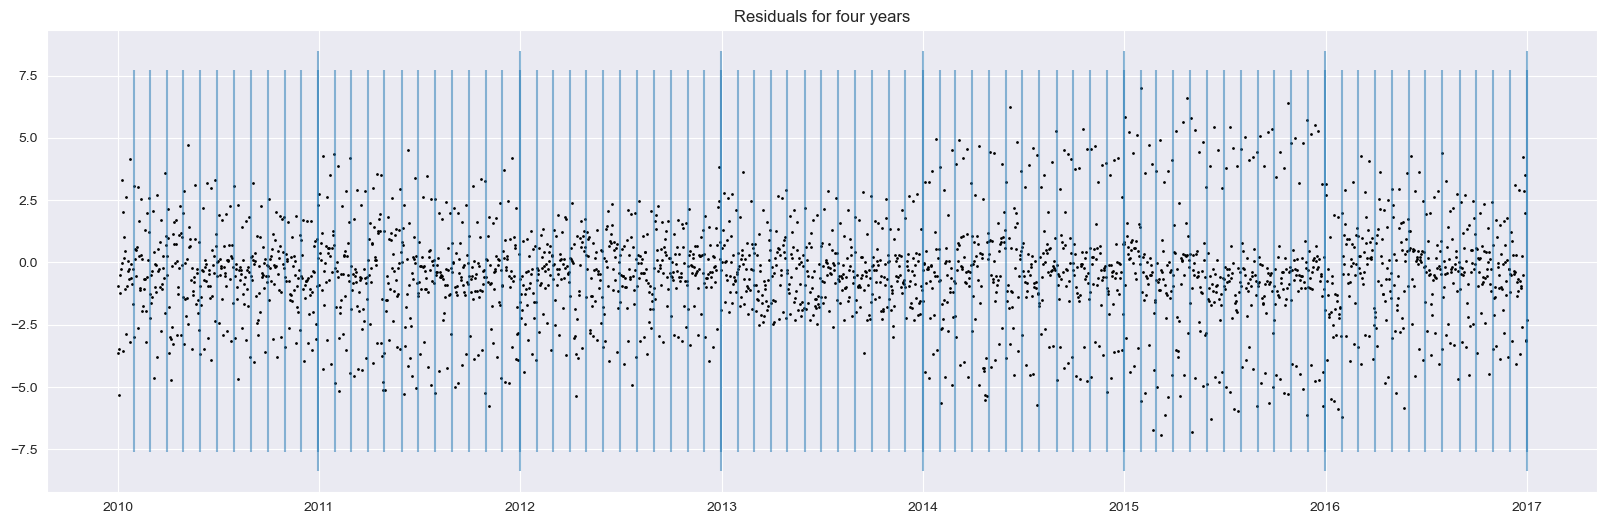

In [18]:
train_df['pred'] = np.exp(model.predict((train_df[features])))
by_date = train_df.dropna().groupby(train_df['date'])
residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200

# Plot all residuals (four-year range, sum of all products)
def plot_all_residuals(residuals):
    plt.figure(figsize=(20,6))
    plt.scatter(residuals.index,
                residuals,
                s=1, color='k')
    plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='M'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5)
    plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='Y'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5)
    plt.title('Residuals for four years')
    plt.show()
    
plot_all_residuals(residuals)


In [24]:
# Plot residuals for interesting intervals
def plot_around(residuals, m, d, w, y0=2010, y1=2017):
    """Plot residuals in an interval of with 2*w around month=m and day=d"""
    plt.figure()
    plt.title(f"Residuals around m={m} d={d}")
    plt.ylim(-40, 40)
    for y in np.arange(y0, y1):
        d0 = pd.Timestamp(date(y, m, d))
        residual_range = residuals[(residuals.index > d0 - timedelta(w)) & 
                                   (residuals.index < d0 + timedelta(w))]
        
        plt.plot([(r - d0).days for r in residual_range.index], residual_range, label=str(y))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    plt.legend()
    plt.show()

In [183]:
# Norway special days
# Easter
# plot_around(residuals, 5, 1, 50,2010,2011) # three moveable peaks depending on Easter
# plot_around(residuals, 5, 1, 50,2011,2012) # three moveable peaks depending on Easter
# plot_around(residuals, 5, 1, 50,2012,2013) # three moveable peaks depending on Easter
# plot_around(residuals, 5, 1, 50,2013,2014) # three moveable peaks depending on Easter
# plot_around(residuals, 5, 1, 50,2014,2015) # three moveable peaks depending on Easter
# plot_around(residuals, 5, 1, 50,2015,2016) # three moveable peaks depending on Easter
# plot_around(residuals, 5, 1, 50,2016,2017) # three moveable peaks depending



In [184]:
# Norway special days
# New year
# plot_around(residuals, 1, 1, 50,2010,2011) # three moveable peaks depending on Easter
# plot_around(residuals, 1, 1, 50,2011,2012) # three moveable peaks depending on Easter
# plot_around(residuals, 1, 1, 50,2012,2013) # three moveable peaks depending on Easter
# plot_around(residuals, 1, 1, 50,2013,2014) # three moveable peaks depending on Easter
# plot_around(residuals, 1, 1, 50,2014,2015) # three moveable peaks depending on Easter
# plot_around(residuals, 1, 1, 50,2015,2016) # three moveable peaks depending on Easter
# plot_around(residuals, 1, 1, 50,2016,2017) # three moveable peaks depending


In [32]:
# calcuulate the average residuals for each date
average_residuals = residuals.groupby(residuals.index.date).mean()
# find the top 10 dates with the highest residuals
top_dates = average_residuals.nlargest(10).index

In [33]:
top_dates

Index([2012-12-22, 2012-11-03, 2012-12-01, 2012-11-24, 2010-02-13, 2010-01-23,
       2013-01-19, 2012-10-27, 2014-11-22, 2013-02-09],
      dtype='object')

In [31]:
top_res = residuals.nlargest(10).index
print(top_res)

date
2013-12-29    32.515968
2016-12-29    32.402477
2016-12-30    32.097694
2011-12-30    31.713755
2011-12-29    31.524399
2013-12-30    28.952164
2010-01-01    28.890213
2015-12-30    28.871731
2010-12-30    27.951315
2015-12-29    27.629503
dtype: float32


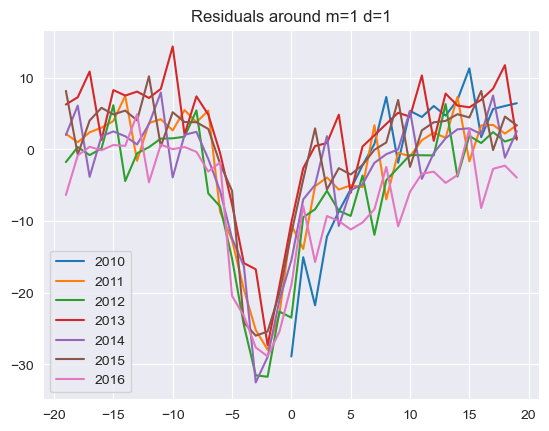

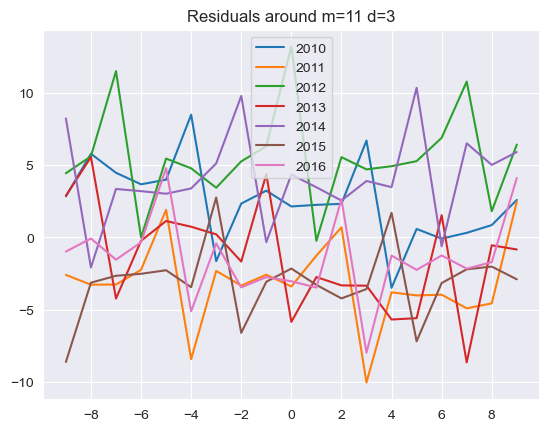

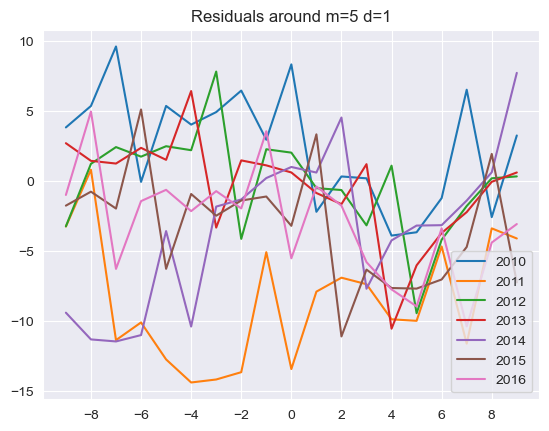

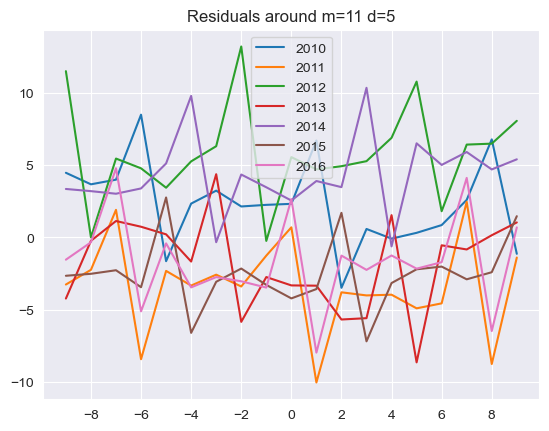

In [35]:

plot_around(residuals, 1, 1, 20) # end of year peak ==> good
plot_around(residuals, 11, 3, 10) # three moveable peaks depending on Easter
#plot_around(residuals, 5, 21, 10) # zoom-in
#plot_around(residuals, 5, 31, 15) # zoom-in

plot_around(residuals, 5, 1, 10) # moveable peak end of June
plot_around(residuals, 11, 5, 10) # moveable peak beginning of November

C:\Users\ITXPC\AppData\Local\Temp\ipykernel_122680\1314448507.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='M'),
C:\Users\ITXPC\AppData\Local\Temp\ipykernel_122680\1314448507.py:27: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='Y'),


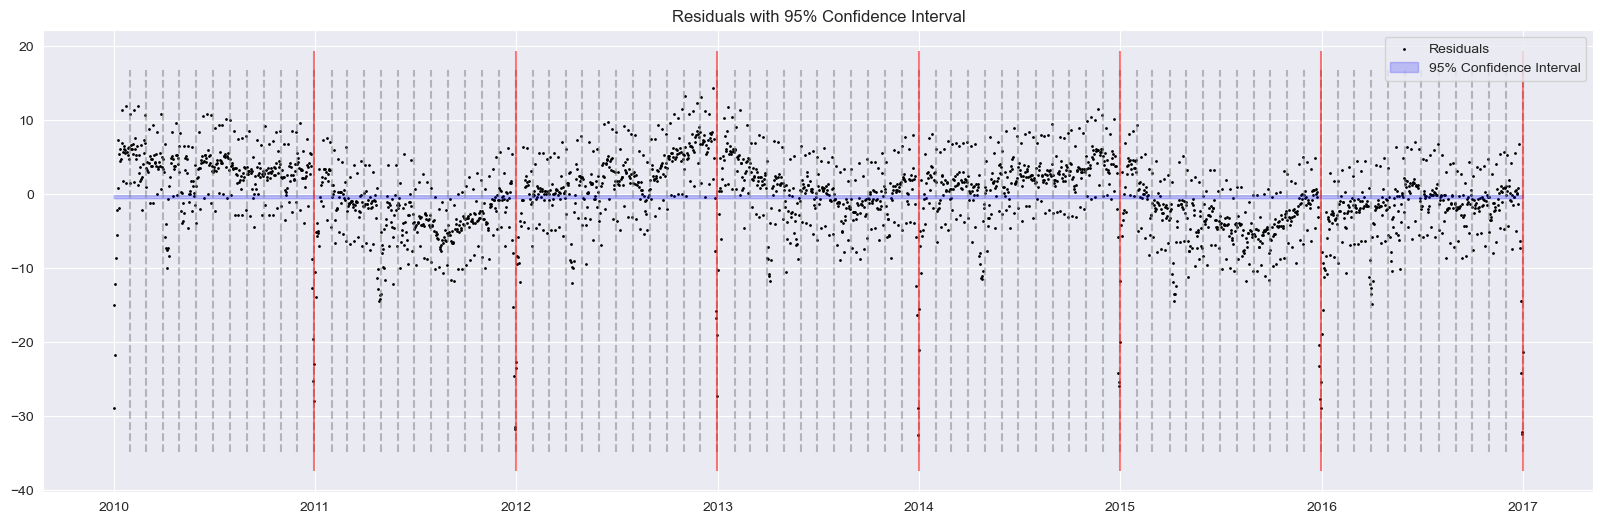

In [20]:
from scipy.stats import norm

def plot_all_residuals_with_ci(residuals):
    plt.figure(figsize=(20,6))
    
    # Calculate confidence intervals
    mean_residuals = residuals.mean()
    std_residuals = residuals.std()
    ci_95 = 1.96 * std_residuals / (len(residuals)**0.5)
    
    # Plot residuals
    plt.scatter(residuals.index, residuals, s=1, color='k', label='Residuals')
    
    # Plot confidence intervals
    plt.fill_between(
        residuals.index,
        mean_residuals - ci_95,
        mean_residuals + ci_95,
        color='blue',
        alpha=0.2,
        label='95% Confidence Interval'
    )
    
    # Add vertical lines for months and years
    plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='M'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5, color='gray', linestyle='--')
    plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='Y'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5, color='red', linestyle='-')
    
    # Add title and legend
    plt.title('Residuals with 95% Confidence Interval')
    plt.legend()
    plt.show()

# Call the function with the residuals
plot_all_residuals_with_ci(residuals)


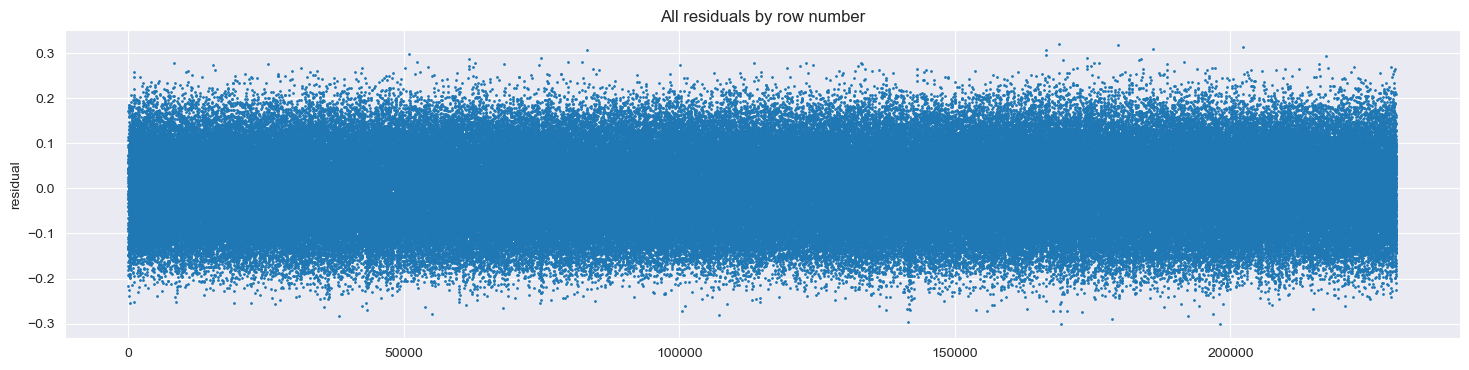

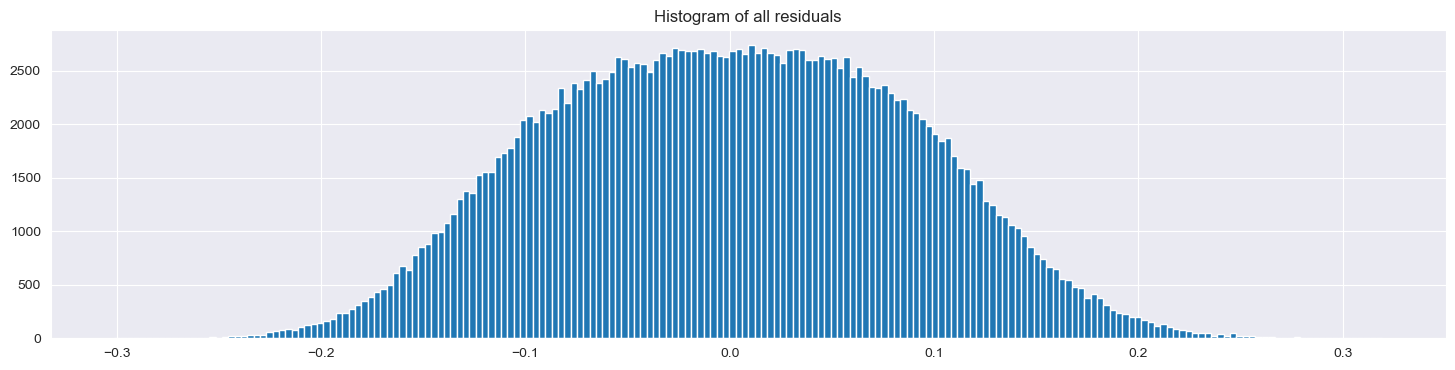

Standard deviation of log residuals: 0.087


In [26]:
residuals = np.log(train_df.pred) - np.log(train_df.num_sold)
plt.figure(figsize=(18, 4))
plt.scatter(np.arange(len(residuals)), residuals, s=1)
plt.title('All residuals by row number')
plt.ylabel('residual')
plt.show()
plt.figure(figsize=(18, 4))
plt.hist(residuals, bins=200)
plt.title('Histogram of all residuals')
plt.show()
print(f"Standard deviation of log residuals: {residuals.std():.3f}")


In [27]:
train_df['dayfix'] = train_df.date.dt.dayofyear
train_df.loc[(train_df.date.dt.year != 2016) & (train_df.date.dt.month >= 3), 'dayfix'] += 1

from scipy.stats import norm
print("Look for residuals beyond", norm.ppf([0.5/365, 364.5/365]))

rr = residuals.groupby(train_df.dayfix).mean()
rrstd = rr.std()
print(f"Standard deviation when grouped by dayofyear: {rrstd:.5f}")
rrdf = pd.DataFrame({'residual': rr, 'z_score': rr / rrstd, 'date': pd.date_range('2016-01-01', '2016-12-31')})
rrdf[rrdf.z_score.abs() > 3]

Look for residuals beyond [-2.99552527  2.99552527]
Standard deviation when grouped by dayofyear: 0.00382


ValueError: array length 366 does not match index length 367